# QF621 Quantitative Trading Strategy
## Group Project | Pair Trading Perfomance Optimization with Machine Learning | G2 
### Prepared by: BAI He, CHENG Shuya, LIANG Yuehui, LI Honglin, LIU Yushan, SHENG Zaizhi



Pair trading is one of the most popular trading strategies since the early 80’s by Morgan Stanley for
finding statistical arbitrage opportunities in the stock market. The logic behind pairs trading is to trade
pairs of stocks belonging to the same industry or having similar characteristics. By choosing a pair of
stocks that move together and assuming that their price is mean reverting, traders can profit from the
deviations from the mean by taking a long-short position in the chosen pair.

# 1. Preparation

## 1.1 Setup Enviroment

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import nltk
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import datetime
import requests
import json
from datetime import date, timedelta
from urllib.request import urlopen, Request
# NLTK VADER for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# Import BDay to determine business day's dates
from pandas.tseries.offsets import BDay
from dateutil.relativedelta import relativedelta
# import lib to prepare for Pair Selection using Machine Learning
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing
from statsmodels.tsa.stattools import coint
from scipy import stats


import warnings
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [3]:
raw_data

PERMNO      date  SICCD TICKER        PRC     SHROUT    maket caps  \
0        10104  20200102   7372   ORCL   53.95000  3207649.0  1.730527e+08   
1        10104  20200103   7372   ORCL   53.76000  3207649.0  1.724432e+08   
2        10104  20200106   7372   ORCL   54.04000  3207649.0  1.733414e+08   
3        10104  20200107   7372   ORCL   54.16000  3207649.0  1.737263e+08   
4        10104  20200108   7372   ORCL   54.13000  3207649.0  1.736300e+08   
...        ...       ...    ...    ...        ...        ...           ...   
130869   93436  20201224   9999   TSLA  661.77002   947901.0  6.272925e+08   
130870   93436  20201228   9999   TSLA  663.69000   947901.0  6.291124e+08   
130871   93436  20201229   9999   TSLA  665.98999   947901.0  6.312926e+08   
130872   93436  20201230   9999   TSLA  694.78003   947901.0  6.585827e+08   
130873   93436  20201231   9999   TSLA  705.66998   947901.0  6.689053e+08   

       maket caps class  
0                     1  
1                     1  
2                     1  
3                     1  
4                     1  
...                 ...  
130869                1  
130870                1  
130871                1  
130872                1  
130873                1  

[130874 rows x 8 columns]

# 2. Pair Selection

<ipython-input-2-89b676d40c40>:32: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  res['maket caps class'][returns.columns].values[:, np.newaxis],
<ipython-input-2-89b676d40c40>:34: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  res['roe'][returns.columns].values[:, np.newaxis])


DBSCAN(eps=3.5, min_samples=3)

Clusters discovered: 8
Total pairs possible in universe: 134421 
Clusters formed: 8
Pairs to evaluate: 556


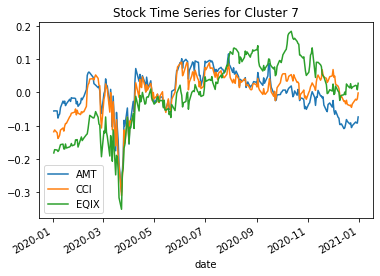

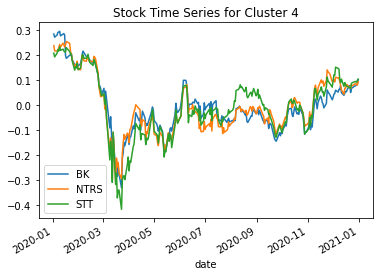

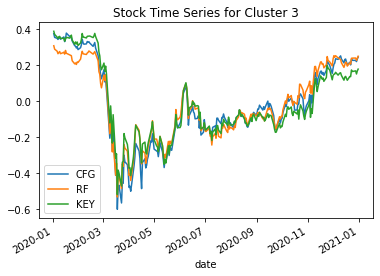

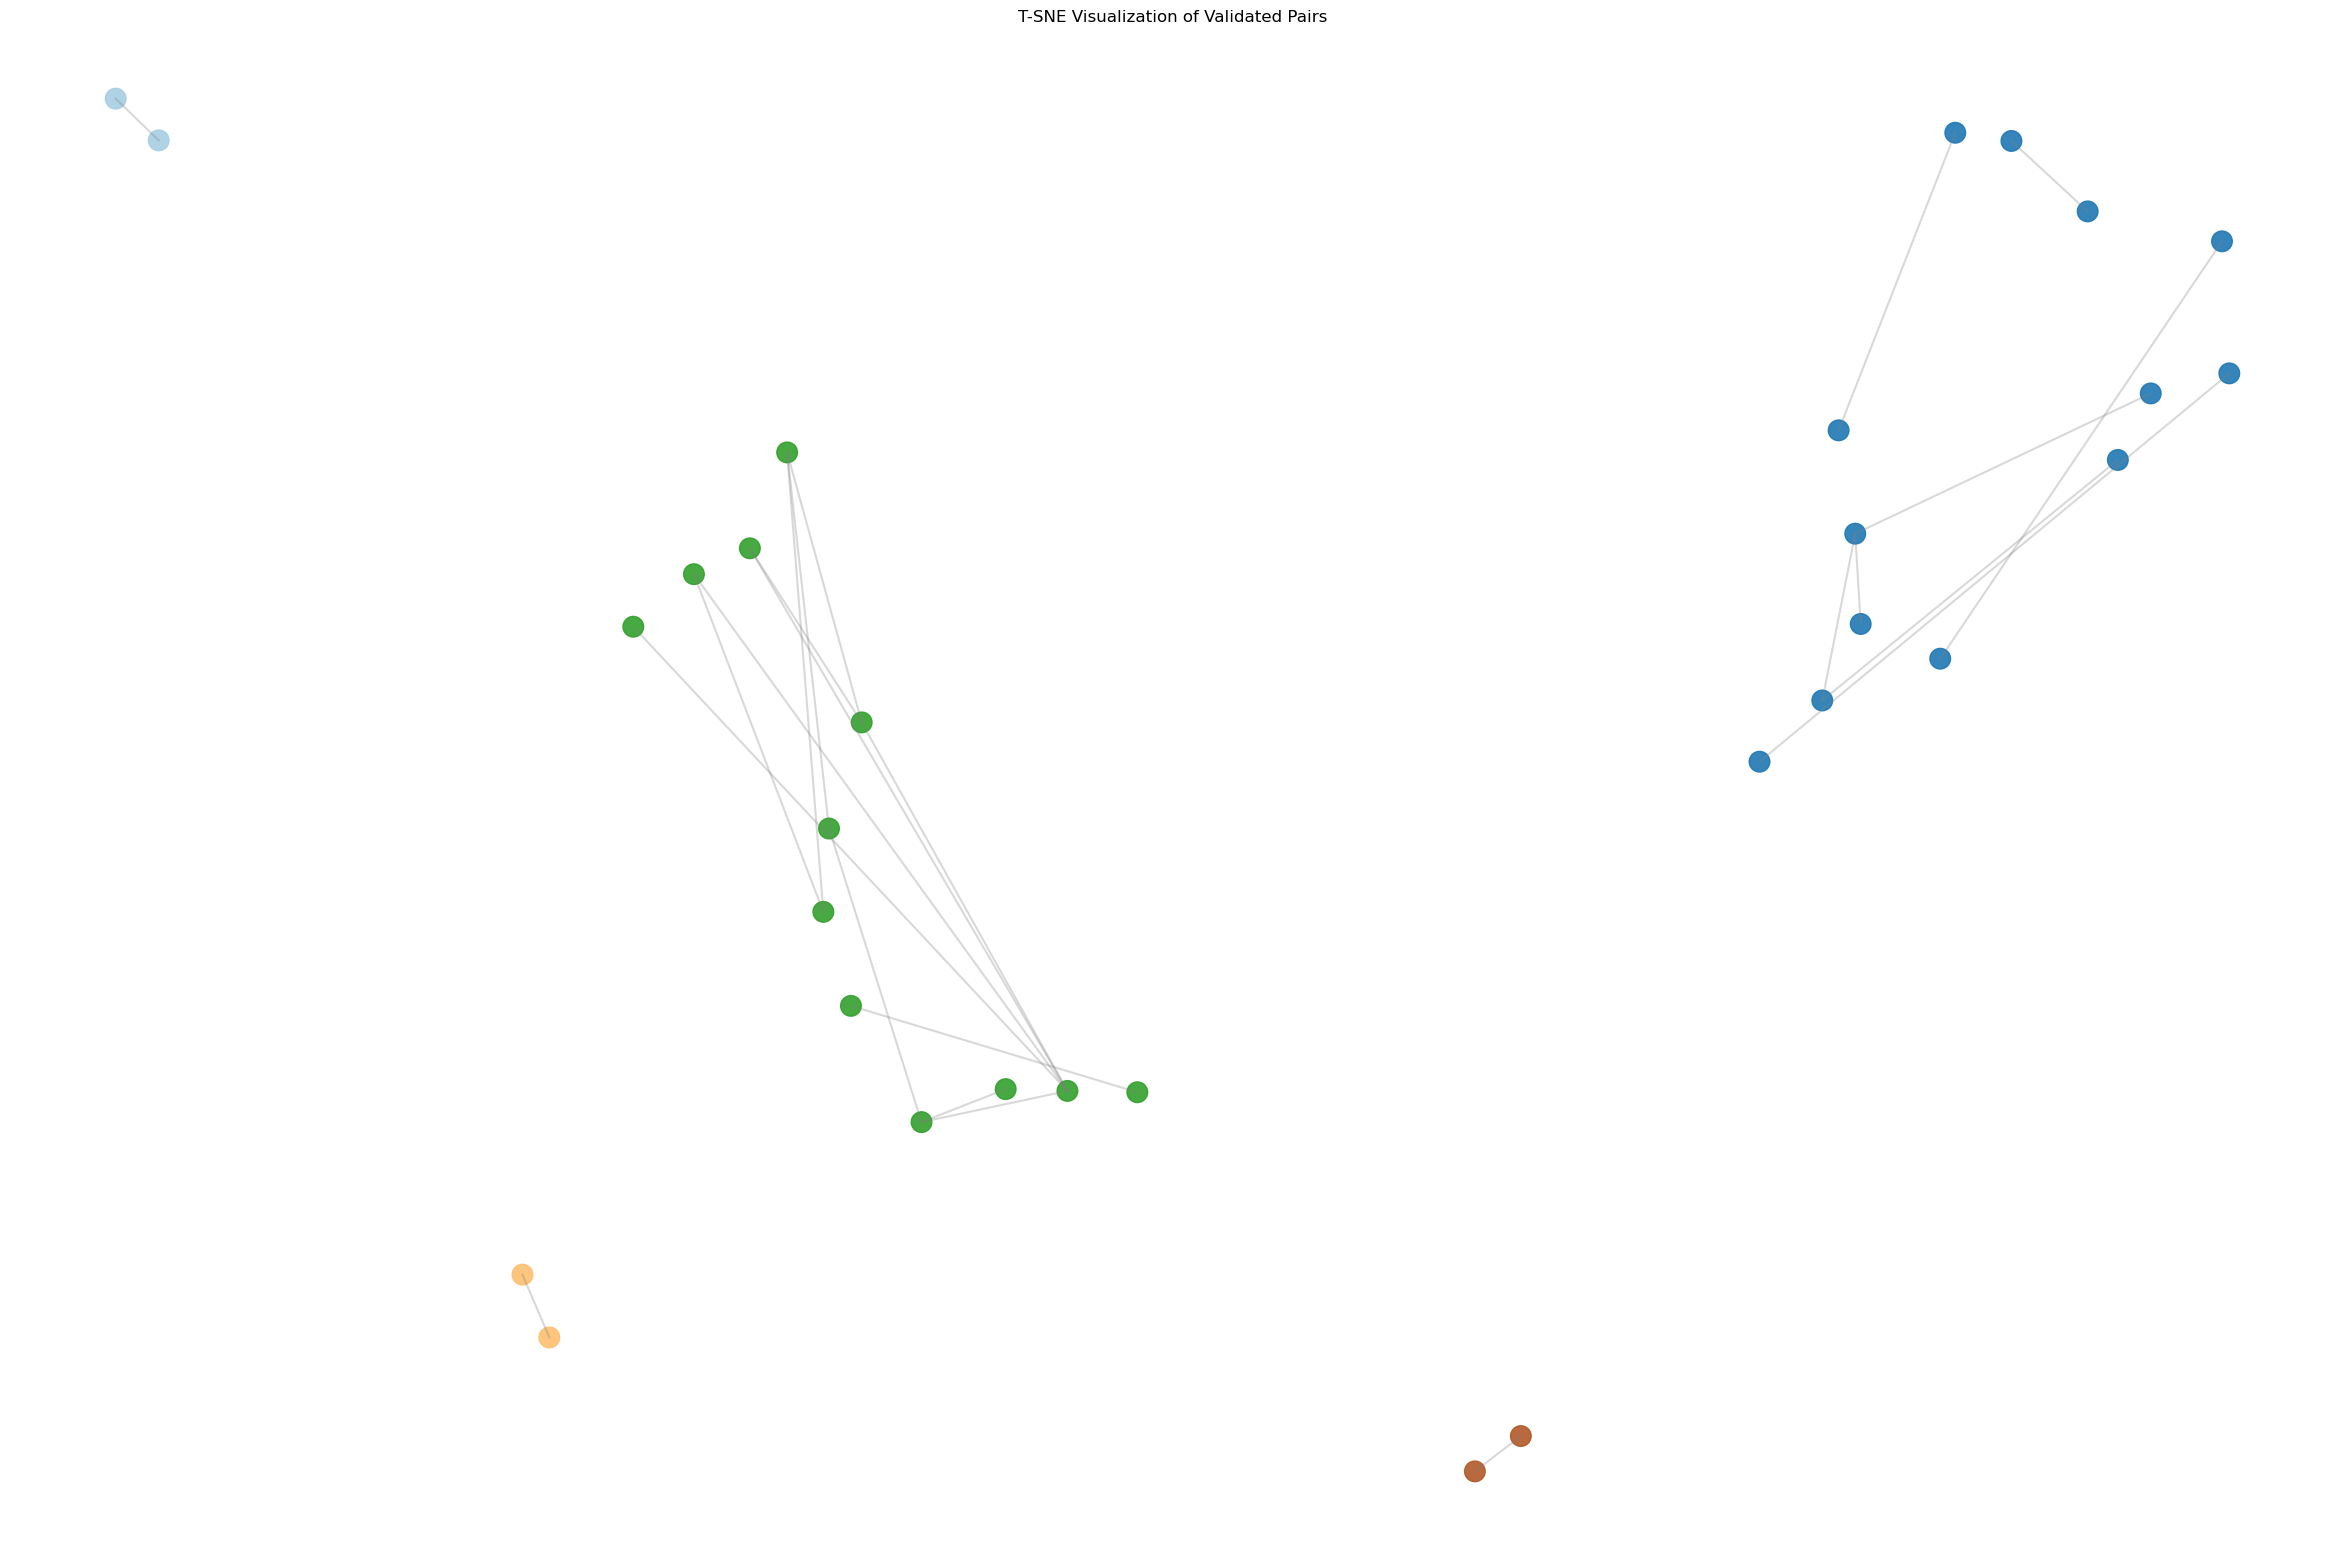

In [2]:
raw_data=pd.read_csv('mkc_r_sic.csv')
raw_data = raw_data[raw_data['TICKER'].notna()]
raw_data['maket caps']=raw_data['PRC']*raw_data['SHROUT']
raw_data['maket caps class']=pd.qcut(raw_data['maket caps'], 4,labels=["4", "3", "2","1"])
roe_data=pd.read_csv('roe.csv')
roe_data = roe_data[roe_data['TICKER'].notna()]
roe_data['roe']=pd.qcut(roe_data['roe'], 4,labels=["4", "3", "2","1"])
roe_data=roe_data[['TICKER','roe']].drop_duplicates(subset=['TICKER'])
roe_data.set_index('TICKER', inplace = True)
res=raw_data[['TICKER','maket caps class','SICCD']].drop_duplicates(subset=['TICKER'])
res.set_index('TICKER', inplace = True)
res=pd.concat([res,roe_data], axis=1)

prices=raw_data[['date']].drop_duplicates(subset=['date']).dropna()
prices['date'] = pd.to_datetime(prices['date'], format='%Y%m%d')
prices.set_index('date', inplace = True)
ticker_list=raw_data['TICKER'].unique().tolist()
for ticker in ticker_list:
    new_col = raw_data[raw_data['TICKER'] == ticker][['date', 'PRC']].drop_duplicates(subset=['date'])
    new_col.rename(columns={'PRC': ticker}, inplace=True)
    new_col['date'] = pd.to_datetime(new_col['date'], format='%Y%m%d')
    new_col.set_index('date', inplace=True)
    prices = pd.concat([prices, new_col], axis=1)
returns = prices.pct_change()
returns=returns.fillna(0)
N_PRIN_COMPONENTS = 50
pca = PCA(n_components=N_PRIN_COMPONENTS)
pca.fit(returns)
pca.components_.T.shape
X = np.hstack(
    (pca.components_.T,
     res['maket caps class'][returns.columns].values[:, np.newaxis],
     res['SICCD'][returns.columns].values[:, np.newaxis],
     res['roe'][returns.columns].values[:, np.newaxis])
)
X = preprocessing.StandardScaler().fit_transform(X)


clf = DBSCAN(eps=3.5, min_samples=3)
print (clf)

clf.fit(X)
labels = clf.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print ("\nClusters discovered: %d" % n_clusters_)

clustered = clf.labels_
ticker_count = len(returns.columns)
print ("Total pairs possible in universe: %d " % (ticker_count*(ticker_count-1)/2))
clustered_series = pd.Series(index=returns.columns, data=clustered.flatten())
clustered_series_all = pd.Series(index=returns.columns, data=clustered.flatten())
clustered_series = clustered_series[clustered_series != -1]
CLUSTER_SIZE_LIMIT = 9999
counts = clustered_series.value_counts()
ticker_count_reduced = counts[(counts>1) & (counts<=CLUSTER_SIZE_LIMIT)]
print ("Clusters formed: %d" % len(ticker_count_reduced))
print ("Pairs to evaluate: %d" % (ticker_count_reduced*(ticker_count_reduced-1)).sum())
X_tsne = TSNE(learning_rate=1000, perplexity=25, random_state=1337).fit_transform(X)
plt.figure(1, facecolor='white', dpi=100,figsize=(30,20 ))
plt.clf()
plt.axis('off')

plt.scatter(
    X_tsne[(labels!=-1), 0],
    X_tsne[(labels!=-1), 1],
    s=100,
    alpha=0.85,
    c=labels[labels!=-1],
    cmap=cm.Paired
)

plt.scatter(
    X_tsne[(clustered_series_all==-1).values, 0],
    X_tsne[(clustered_series_all==-1).values, 1],
    s=100,
    alpha=0.05
)

plt.title('T-SNE of all Stocks with DBSCAN Clusters Noted');

plt.barh(
    range(len(clustered_series.value_counts())),
    clustered_series.value_counts()
)
plt.title('Cluster Member Counts')
plt.xlabel('Stocks in Cluster')
plt.ylabel('Cluster Number');

# get the number of stocks in each cluster
counts = clustered_series.value_counts()

# let's visualize some clusters
cluster_vis_list = list(counts[(counts<20) & (counts>1)].index)[::-1]

# plot a handful of the smallest clusters
for clust in cluster_vis_list[0:min(len(cluster_vis_list), 3)]:
    tickers = list(clustered_series[clustered_series==clust].index)
    means = np.log(prices[tickers].mean())
    data = np.log(prices[tickers]).sub(means)
    data.plot(title='Stock Time Series for Cluster %d' % clust)


def find_cointegrated_pairs(data, significance=0.05):
    # This function is from https://www.quantopian.com/lectures/introduction-to-pairs-trading
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < significance:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

cluster_dict = {}
for i, which_clust in enumerate(ticker_count_reduced.index):
    tickers = clustered_series[clustered_series == which_clust].index

    score_matrix, pvalue_matrix, pairs = find_cointegrated_pairs(
        prices[tickers].fillna(0)
    )
    cluster_dict[which_clust] = {}
    cluster_dict[which_clust]['score_matrix'] = score_matrix
    cluster_dict[which_clust]['pvalue_matrix'] = pvalue_matrix
    cluster_dict[which_clust]['pairs'] = pairs
pairs = []
for clust in cluster_dict.keys():
    pairs.extend(cluster_dict[clust]['pairs'])
stocks = np.unique(pairs)
X_df = pd.DataFrame(index=returns.T.index, data=X)
in_pairs_series = clustered_series.loc[stocks]
stocks = list(np.unique(pairs))
X_pairs = X_df.loc[stocks]

X_tsne = TSNE(learning_rate=50, perplexity=3, random_state=1337).fit_transform(X_pairs)

plt.figure(1, facecolor='white')
plt.clf()
plt.axis('off')
for pair in pairs:
    loc1 = X_pairs.index.get_loc(pair[0])
    x1, y1 = X_tsne[loc1, :]

    loc2 = X_pairs.index.get_loc(pair[1])
    x2, y2 = X_tsne[loc2, :]

    plt.plot([x1, x2], [y1, y2], 'k-', alpha=0.3, c='gray');

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=220, alpha=0.9, c=[in_pairs_series.values], cmap=cm.Paired)
plt.title('T-SNE Visualization of Validated Pairs');

## 2.1 Pair Selection Results

In [14]:
pairs

[('ED', 'NI'),
 ('SO', 'EXC'),
 ('PPL', 'ETR'),
 ('PPL', 'AEP'),
 ('CMS', 'LNT'),
 ('WEC', 'AEE'),
 ('ETR', 'AEP'),
 ('AEE', 'LNT'),
 ('ES', 'LNT'),
 ('D', 'AWK'),
 ('WM', 'RSG'),
 ('PEP', 'RSG'),
 ('PEP', 'CMCSA'),
 ('CL', 'COST'),
 ('CL', 'CMCSA'),
 ('VZ', 'RSG'),
 ('VZ', 'MDLZ'),
 ('MDLZ', 'CMCSA'),
 ('GOOG', 'GOOGL'),
 ('CCI', 'EQIX'),
 ('SBAC', 'EQIX'),
 ('CPB', 'K')]

# 3. Pair Trading Strategy

First we verify the status of cointegration by checking historical datasets
bandwidth determines the number of data points for consideration
bandwidth is 50 by default
if the status is valid, we check the signals
when z stat gets above the upper bound
we long the bearish one and short the bullish one, vice versa.

In [15]:
def signal_generation(asset1,asset2,method,vader_Buy, vader_Sell, rating_score, bandwidth=50):
    
    signals=pd.DataFrame()
    signals['asset1']=asset1['Close']
    signals['asset2']=asset2['Close']
    
    #signals only imply holding
    signals['signals1']=0    
    signals['signals2']=0
    
    #initialize
    prev_status=False
    signals['z']=np.nan
    signals['z upper limit']=np.nan
    signals['z lower limit']=np.nan
    signals['fitted']=np.nan    
    signals['residual']=np.nan
    signals["sentiment_buy"] = np.where(signals.index.isin(vader_Buy), 1, 0)
    signals["sentiment_sell"] = np.where(signals.index.isin(vader_Sell),-1, 0)
    signals = signals.merge(rating_score, left_index=True, right_index=True)
    
    #signal processing
    for i in range(bandwidth,len(signals)):
        
        #cointegration test
        coint_status,model=EG_method(signals['asset1'].iloc[i-bandwidth:i],
                                  signals['asset2'].iloc[i-bandwidth:i])
                
        #cointegration breaks
        #clear existing positions
        if prev_status and not coint_status:           
            if signals.at[signals.index[i-1],'signals1']!=0:
                signals.at[signals.index[i],'signals1']=0
                signals.at[signals.index[i],'signals2']=0
                signals['z'].iloc[i:]=np.nan
                signals['z upper limit'].iloc[i:]=np.nan
                signals['z lower limit'].iloc[i:]=np.nan
                signals['fitted'].iloc[i:]=np.nan    
                signals['residual'].iloc[i:]=np.nan
        
        #cointegration starts
        #set the trigger conditions
        #this is no forward bias
        #just to minimize the calculation done in pandas
        if not prev_status and coint_status:
            
            #predict the price to compute the residual       
#             signals['fitted'].iloc[i:]=model.predict(sm.add_constant(signals['asset1'].iloc[i:]))
            signals['fitted'].iloc[i:]=model.predict(sm.add_constant(signals['asset1'].iloc[i:], prepend=True, has_constant='add'))
            signals['residual'].iloc[i:]=signals['asset2'].iloc[i:]-signals['fitted'].iloc[i:]
            
            #normalize the residual to get z stat
            #z should be a white noise following N(0,1)
            signals['z'].iloc[i:]=(signals['residual'].iloc[i:]-np.mean(model.resid))/np.std(model.resid)
                        
            #create thresholds
            #conventionally one sigma is the threshold
            #two sigma reaches 95% which is relatively difficult to trigger
            signals['z upper limit'].iloc[i:]=signals['z'].iloc[i]+np.std(model.resid)
            signals['z lower limit'].iloc[i:]=signals['z'].iloc[i]-np.std(model.resid)

                
################# Original Pair Trading Strategy with no attention/sentiment analysis ##############                
        if coint_status and signals['z'].iloc[i]>signals['z upper limit'].iloc[i]:
             signals.at[signals.index[i],'signals1']=1
        if coint_status and signals['z'].iloc[i]<signals['z lower limit'].iloc[i]:
             signals.at[signals.index[i],'signals1']=-1 
        prev_status=coint_status    
    
    #signals only imply holding
    #we take the first order difference to obtain the execution signal
    signals['positions1']=signals['signals1'].diff()
    
    #only need to generate trading signal of one asset
    #the other one should be the opposite direction
    signals['signals2']=-signals['signals1']
    signals['positions2']=signals['signals2'].diff()   
    
    return signals

In [16]:
#position visualization
def plot(data,ticker1,ticker2):    
    
#     plt.style.use('seaborn-white')
    fig=plt.figure(figsize=(10,5))
    bx=fig.add_subplot(111)   
    bx2=bx.twinx()
    
    #viz two different assets
    asset1_price,=bx.plot(data.index,data['asset1'],
                          c='#113aac',alpha=0.7)
    asset2_price,=bx2.plot(data.index,data['asset2'],
                          c='#907163',alpha=0.7)

    #viz positions
    asset1_long,=bx.plot(data.loc[data['positions1']==1].index,
                data['asset1'][data['positions1']==1],
                lw=0,marker='^',markersize=8,
                c='g',alpha=0.7)
    asset1_short,=bx.plot(data.loc[data['positions1']==-1].index,
                data['asset1'][data['positions1']==-1],
                lw=0,marker='v',markersize=8,
                c='r',alpha=0.7)
    asset2_long,=bx2.plot(data.loc[data['positions2']==1].index,
                 data['asset2'][data['positions2']==1],
                 lw=0,marker='^',markersize=8,
                 c='g',alpha=0.7)
    asset2_short,=bx2.plot(data.loc[data['positions2']==-1].index,
                 data['asset2'][data['positions2']==-1],
                 lw=0,marker='v',markersize=8,
                 c='r',alpha=0.7)

    #set labels
    bx.set_ylabel(ticker1,)
    bx2.set_ylabel(ticker2,rotation=270)
    bx.yaxis.labelpad=15
    bx2.yaxis.labelpad=15
    bx.set_xlabel('Date')
    bx.xaxis.labelpad=15

    plt.legend([asset1_price,asset2_price,asset1_long,asset1_short],
               [ticker1,ticker2,
               'LONG','SHORT'],
               loc='lower left')

    plt.title('Pair Trading')
    plt.xlabel('Date')
    plt.grid(True)
    plt.show()

In [17]:
def portfolio(data, capital):
    # initial capital to calculate the actual pnl
    capital0 = capital

    # shares to buy of each position
    # this is no forward bias
    # just ensure we have enough €€€ to purchase shares when the price peaks
    # Mathematical division that rounds down to nearest integer.
    # The floor division operator is //. For example, the expression 11 // 4 evaluates
    # to 2 in contrast to the 2.75 returned by float true division.
    positions1 = capital0 // max(data['asset1'])
    positions2 = capital0 // max(data['asset2'])

    # cumsum1 column is created to check the holding of the position
    data['cumsum1'] = data['positions1'].cumsum()

    # since there are two assets, we calculate each asset separately
    # in the end we aggregate them into one portfolio

    portfolio = pd.DataFrame()
    portfolio['asset1'] = data['asset1']
    portfolio['holdings1'] = data['cumsum1'] * data['asset1'] * positions1
    portfolio['trading cost 1'] = (data['asset1'] * positions1 * data['positions1'] * 0.0005).abs()
    portfolio['Cum trading cost 1'] = portfolio['trading cost 1'].cumsum()
    portfolio['cash1'] = capital0 - (data['positions1'] * data['asset1'] * positions1).cumsum() - portfolio[
        'Cum trading cost 1']
    portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
    portfolio['return1'] = portfolio['total asset1'].pct_change()
    portfolio['positions1'] = data['positions1']

    data['cumsum2'] = data['positions2'].cumsum()
    portfolio['asset2'] = data['asset2']
    portfolio['holdings2'] = data['cumsum2'] * data['asset2'] * positions2
    portfolio['trading cost 2'] = (data['asset2'] * positions1 * data['positions2'] * 0.0005).abs()
    portfolio['Cum trading cost 2'] = portfolio['trading cost 2'].cumsum()
    portfolio['cash2'] = capital0 - (data['positions2'] * data['asset2'] * positions2).cumsum() - portfolio[
        'Cum trading cost 2']
    portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
    portfolio['return2'] = portfolio['total asset2'].pct_change()
    portfolio['positions2'] = data['positions2']

    portfolio['z'] = data['z']
    portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
    portfolio['z upper limit'] = data['z upper limit']
    portfolio['z lower limit'] = data['z lower limit']

    # plotting the asset value change of the portfolio
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111)
    ax2 = ax.twinx()

    total_asset_performance, = ax.plot(portfolio['total asset'], c='#46344e')
    z_stats, = ax2.plot(portfolio['z'], c='#4f4a41', alpha=0.2)

    threshold = ax2.fill_between(portfolio.index, portfolio['z upper limit'],
                                 portfolio['z lower limit'],
                                 alpha=0.2, color='#ffb48f')

    # due to the opposite direction of trade for 2 assets
    # we will not plot positions on asset performance
    ax.set_ylabel('Asset Value')
    ax2.set_ylabel('Z Statistics', rotation=270)
    ax.yaxis.labelpad = 15
    ax2.yaxis.labelpad = 15
    ax.set_xlabel('Date')
    ax.xaxis.labelpad = 15

    plt.legend([z_stats, threshold, total_asset_performance],
               ['Z Statistics', 'Z Statistics +-1 Sigma',
                'Total Asset Performance'], loc='best')

    plt.grid(True)
    plt.title('Total Asset')
    plt.show()
    
    return portfolio

In [18]:
# Use Engle-Granger two-step method to test cointegration
# the malaise of two-step is the order of the cointegration
# unlike johansen test, two-step method can only detect the first order
def EG_method(X,Y,show_summary=False):
    
    #step 1
    #estimate long run equilibrium
    model1=sm.OLS(Y,sm.add_constant(X)).fit()
    epsilon=model1.resid
    
    if show_summary:
        print('\nStep 1\n')
        print(model1.summary())
    
    #check p value of augmented dickey fuller test
    #if p value is no larger than 5%, stationary test is passed
    if sm.tsa.stattools.adfuller(epsilon)[1]>0.05:
        return False,model1
    
    #take first order difference of X and Y plus the lagged residual from step 1
    X_dif=sm.add_constant(pd.concat([X.diff(),epsilon.shift(1)],axis=1).dropna())
    Y_dif=Y.diff().dropna()        
    
    #step 2
    #estimate error correction model
    model2=sm.OLS(Y_dif,X_dif).fit()
    
    if show_summary:
        print('\nStep 2\n')
        print(model2.summary())
    
    #adjustment coefficient must be negative
    if list(model2.params)[-1]>0:
        return False,model1
    else:
        return True,model1


In [19]:
#Get the business day for which particular news headline should be used to make trade calls
def get_trade_open(date):
    curr_date_open = pd.to_datetime(date).floor('d').replace(hour=13, minute=30) - BDay(0)
    curr_date_close = pd.to_datetime(date).floor('d').replace(hour=20, minute=0) - BDay(0)

    prev_date_close = (curr_date_open - BDay()).replace(hour=20, minute=0)
    next_date_open = (curr_date_close + BDay()).replace(hour=13, minute=30)

    if ((pd.to_datetime(date) >= prev_date_close) & (pd.to_datetime(date) < curr_date_open)):
        return curr_date_open
    elif ((pd.to_datetime(date) >= curr_date_close) & (pd.to_datetime(date) < next_date_open)):
        return next_date_open
    else:
        return None

In [20]:
def getSentiment(ticker,stdate,eddate):
    base_url = 'https://finnhub.io/api/v1/company-news?'
    token = 'c32t6giad3ifq943t68g'
    r = requests.get(base_url, params = {'symbol': ticker,'token':token, 'from':stdate, 'to':eddate})
    text = r.text
    if text == "[]":
        vader_Buy=[]
        vader_Sell=[]
        return vader_Buy, vader_Sell
    
    else:
        company_news = json.loads(text)
        company_news_pd = pd.DataFrame(company_news)
        news_df = pd.concat([company_news_pd['headline'].apply(pd.Series)], axis=1)
        company_news_pd['datetime'] = [(datetime.utcfromtimestamp(i).strftime('%Y-%m-%d %H:%M:%S')) for i in company_news_pd['datetime'] ]


        final_news = company_news_pd.loc[:, ['datetime', 'headline']]
        final_news['datetime'] = pd.to_datetime(final_news['datetime'])
        final_news.sort_values(by='datetime', inplace=True)


        # Apply the above function to get the trading time for each news headline
        final_news["trading_time"] = final_news["datetime"].apply(get_trade_open)
        final_news = final_news[pd.notnull(final_news['trading_time'])]
        final_news['Date'] = pd.to_datetime(pd.to_datetime(final_news['trading_time']).dt.date)

        # In[7]:
        cs = []
        analyzer = SentimentIntensityAnalyzer()
        for row in range(len(final_news)):
            cs.append(analyzer.polarity_scores(final_news['headline'].iloc[row])['compound'])

        final_news['compound_vader_score'] = cs
        final_news = final_news[(final_news[['compound_vader_score']] != 0).all(axis=1)].reset_index(drop=True)

        unique_dates = final_news['Date'].unique()
        grouped_dates = final_news.groupby(['Date'])
        keys_dates = list(grouped_dates.groups.keys())

        max_cs = []
        min_cs = []

        for key in grouped_dates.groups.keys():
            data = grouped_dates.get_group(key)
            if data["compound_vader_score"].max() > 0:
                max_cs.append(data["compound_vader_score"].max())
            elif data["compound_vader_score"].max() < 0:
                max_cs.append(0)

            if data["compound_vader_score"].min() < 0:
                min_cs.append(data["compound_vader_score"].min())
            elif data["compound_vader_score"].min() > 0:
                min_cs.append(0)

        extreme_scores_dict = {'Date': keys_dates, 'max_scores': max_cs, 'min_scores': min_cs}
        extreme_scores_df = pd.DataFrame(extreme_scores_dict)

        final_scores = []
        for i in range(len(extreme_scores_df)):
            final_scores.append(extreme_scores_df['max_scores'].values[i] + extreme_scores_df['min_scores'].values[i])

        extreme_scores_df['final_scores'] = final_scores

        # VADER trade calls - with threshold
        vader_Buy=[]
        vader_Sell=[]
        for i in range(len(extreme_scores_df)):
            if extreme_scores_df['final_scores'].values[i] > 0.20:
                vader_Buy.append(extreme_scores_df['Date'].iloc[i].date())
            elif extreme_scores_df['final_scores'].values[i] < -0.20:
                vader_Sell.append(extreme_scores_df['Date'].iloc[i].date())
        return vader_Buy, vader_Sell

In [21]:
def getAnalystSentiment(ticker,stdate,eddate):
    start_date = datetime.fromisoformat(stdate)
    end_date = datetime.fromisoformat(eddate)
    delta = timedelta(days=1)
    stock = yf.Ticker(ticker)
    rating_score=[]

    while end_date>=start_date:
        end_date_str = end_date.strftime("%Y-%m-%d")
        end_date_str_mon = datetime.fromisoformat(end_date_str)+ relativedelta(months=-1)
        if stock.recommendations is not None:
            rating_action_stock = stock.recommendations.loc[end_date_str_mon:eddate]
            rating_score.append(rating_action_stock[rating_action_stock["Action"]=="up"]["Firm"].count()*1 + rating_action_stock[rating_action_stock["Action"]=="down"]["Firm"].count()*-1 +   rating_action_stock[rating_action_stock["Action"]=="main"]["Firm"].count()*0)
        else:
            rating_score.append(0)
        
        end_date -= delta
    
    # rating_score
    rating_score_reverse = rating_score[::-1]
    idx = pd.date_range(stdate, eddate, freq="D")
    rating_action_stock_final = pd.DataFrame(data = rating_score_reverse, columns =["score"])
    rating_action_stock_final["Datetime"] = idx
    rating_action_stock_final_reIndex = rating_action_stock_final.set_index("Datetime")

    return rating_action_stock_final_reIndex

In [22]:
def singelPair(pair, capital, stdate,eddate):
    
    ticker1=pair[0]
    ticker2=pair[1]

    #extract data
    asset1=yf.download(ticker1,start=stdate,end=eddate)
    asset2=yf.download(ticker2,start=stdate,end=eddate)  

    #getSentiment
    buy_sentiment, sell_sentiment = getSentiment(ticker1,stdate,eddate)
    rating_score = getAnalystSentiment(ticker1,stdate,eddate)

    #create signals
    signals=signal_generation(asset1,asset2,EG_method,buy_sentiment,sell_sentiment,rating_score)

    #only viz the part where trading signals occur
    if signals['z'].dropna().size !=0:
        ind = signals['z'].dropna().index[0]
    else:ind = signals['z'].dropna()

    #viz positions
    plot(signals[ind:],ticker1,ticker2)    

    #viz portfolio performance
    portfolio_details=portfolio(signals[ind:], capital)
    return  portfolio_details

In [23]:
#original trading strategy
def main():  
    stdate='2020-01-01'
    eddate='2021-01-01'
    total_capital = 1000000
    capital = total_capital/(len(pairs)*2)
    portfolio_details_list=[]
    for pair in pairs:
        
        pair_portfolio = singelPair(list(pair),capital,stdate,eddate)
        portfolio_details_list.append(pair_portfolio["total asset"])

    overall_pnl = pd.concat(portfolio_details_list, axis=1,join="inner")
    overall_pnl['pnl'] = overall_pnl.sum(axis=1)-total_capital
       
    overall_pnl['daily_pnl'] = (overall_pnl['pnl']-overall_pnl['pnl'].shift(periods=1, fill_value=overall_pnl['pnl'][0]/total_capital))/total_capital

    pnlPerformance(overall_pnl['daily_pnl'], "MARKET NEUTRAL")

In [24]:
def pnlPerformance(pnl, label):
    cumpnl = pnl.cumsum(skipna = True)
    import matplotlib.pyplot as plt
    import numpy as np
    sharpe = pnl.mean()/np.std(pnl)
    sharpe = sharpe*np.sqrt(252)
    print("")
    print ("PERFORMANCE STATISTICS FOR "+label);
    print("Daily annualized sharpe: "+str(sharpe))
    print ("Average annual returns: "+str(pnl.mean()*252*100)+"%")
    print ("Total returns: "+str(pnl.sum()*100)+"%");
    print(cumpnl)
    highwatermark_df = cumpnl.cummax();
    drawdown_df = cumpnl - highwatermark_df;
    maxdrawdown = drawdown_df.min();
    print ("Max drawdown: "+str(maxdrawdown*100)+"%");
#     plt.plot(cumpnl.values, label = label);
#     plt.legend();
#     plt.title("Cumulative PNL chart")
# #     plt.show(block=False);
  
    fig=plt.figure(figsize=(10,5))
    bx=fig.add_subplot(111)   
#     bx2=bx.twinx()
    
    #viz two different assets
    overall_return,=bx.plot(pnl.index,cumpnl.values,
                          c='#113aac',alpha=0.7)
    plt.title("Cumulative PNL chart")
    plt.legend();
#     plt.legend([overall_return],
#                loc='lower left')
#     plt.savefig("Cumulative PNL chart.png")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


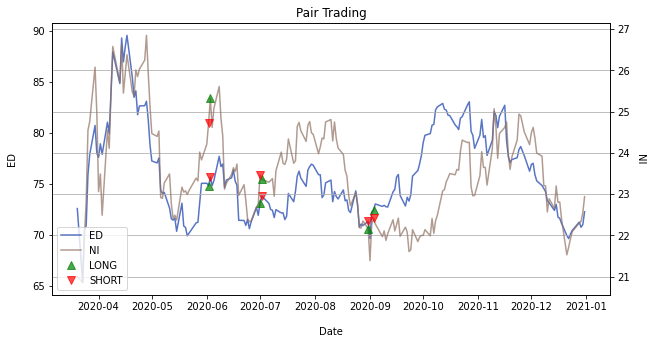

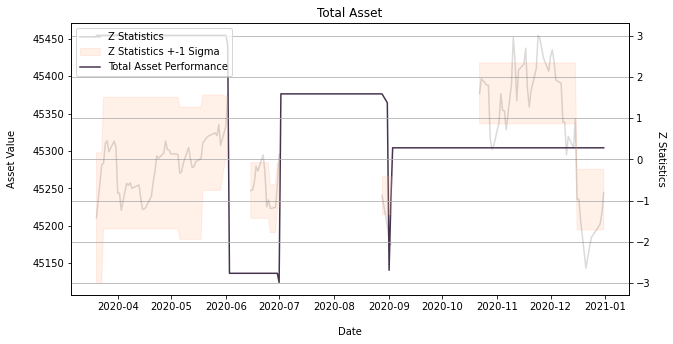

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


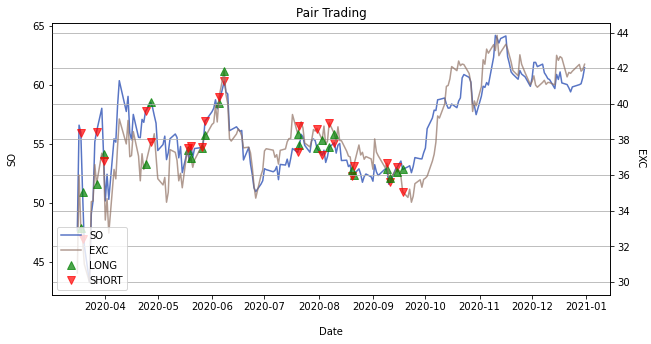

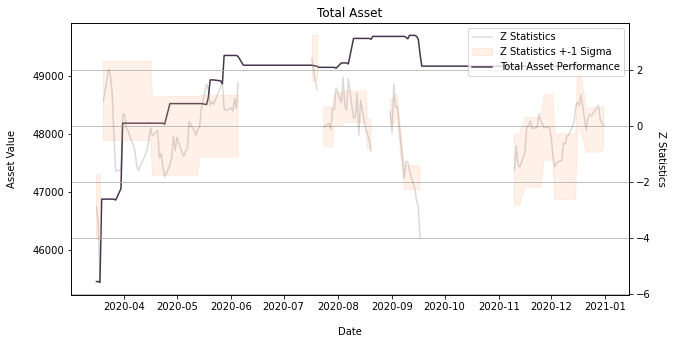

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


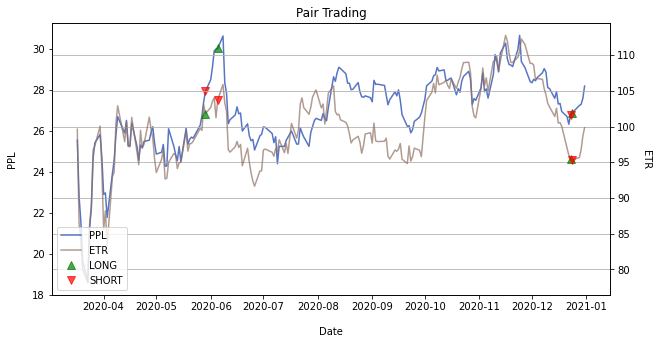

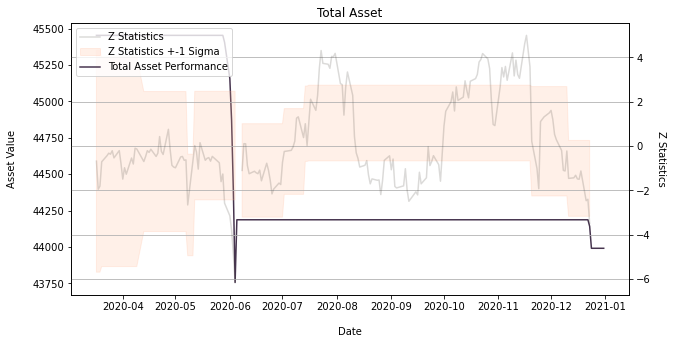

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


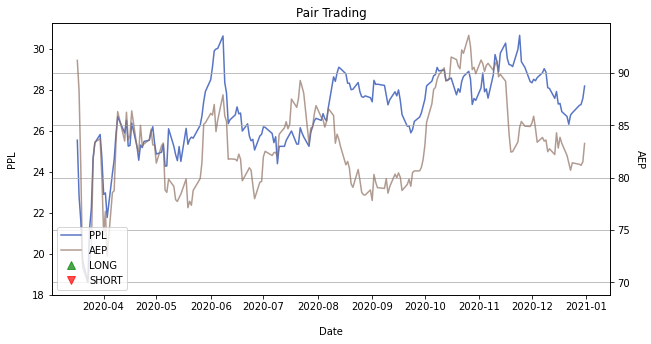

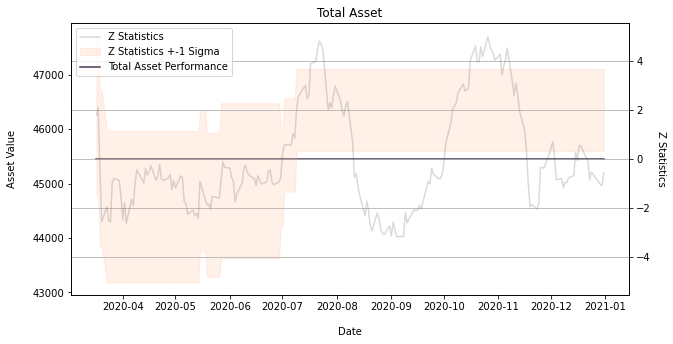

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


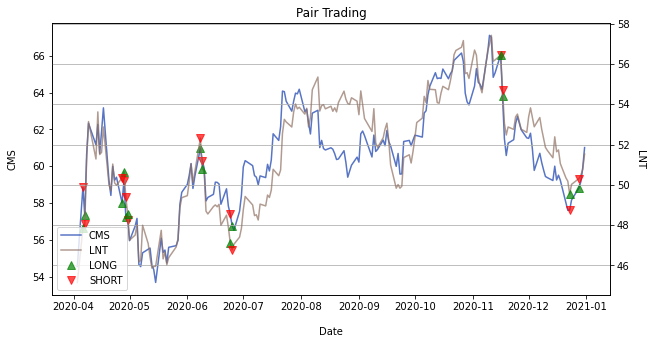

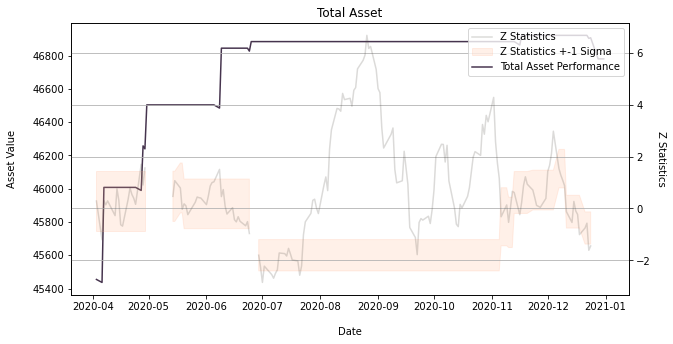

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


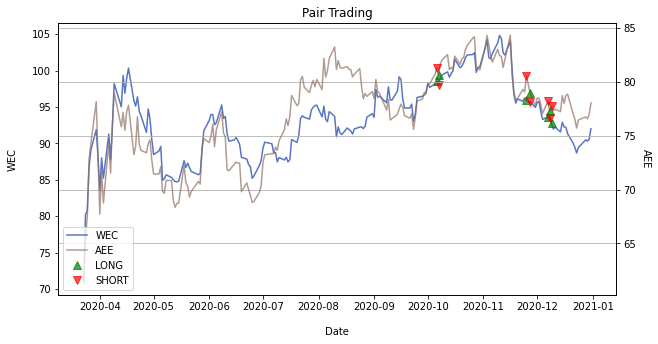

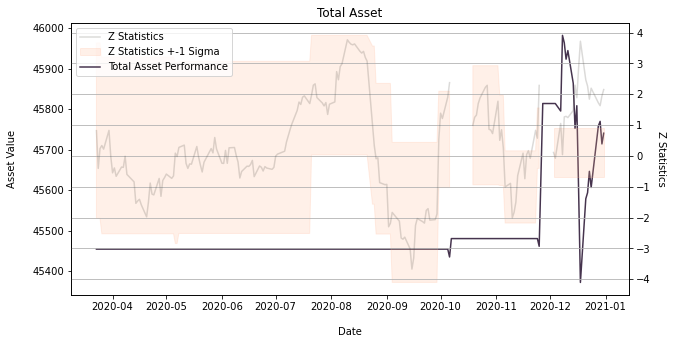

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


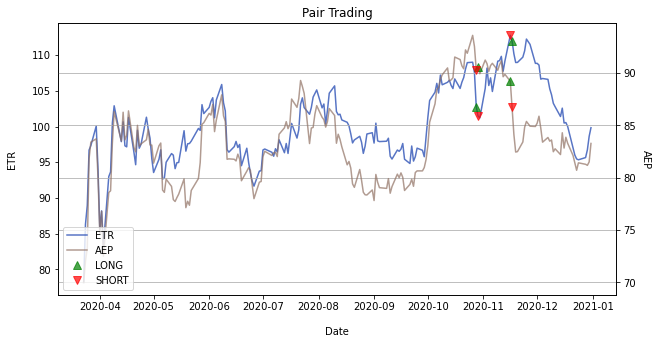

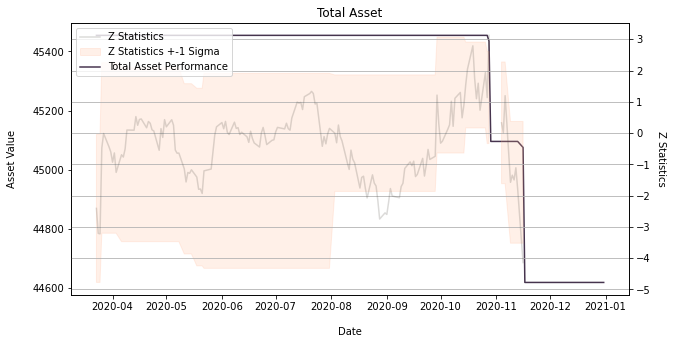

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


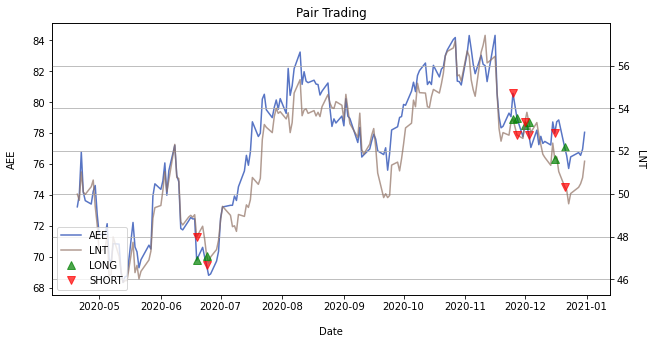

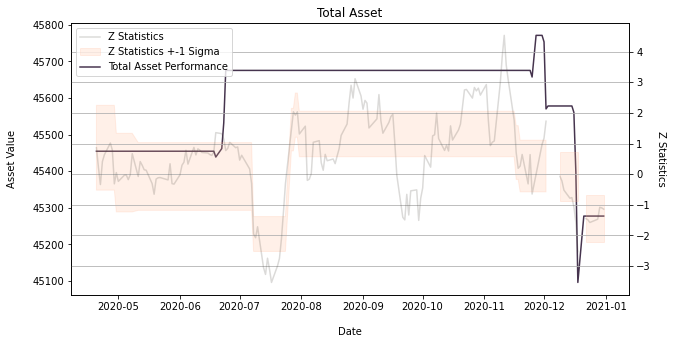

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


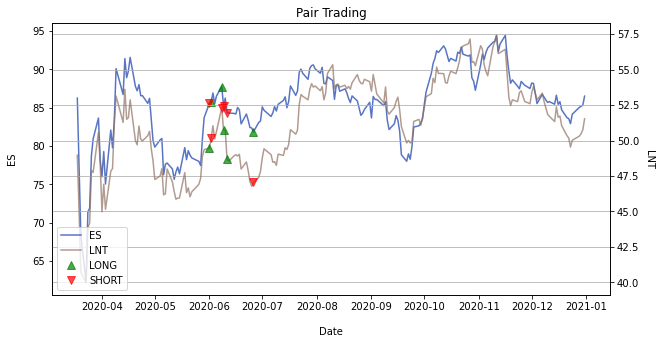

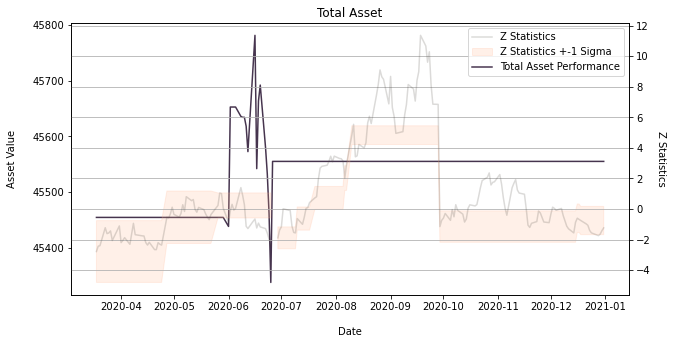

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


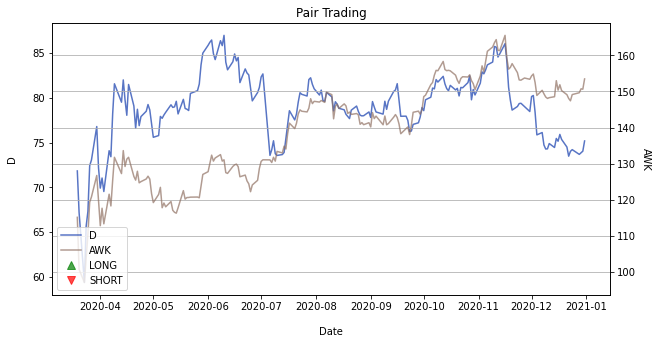

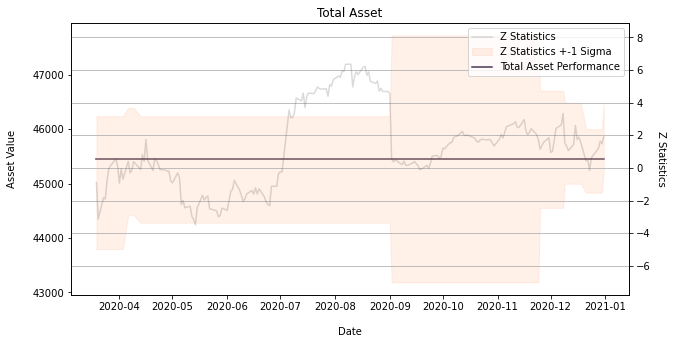

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


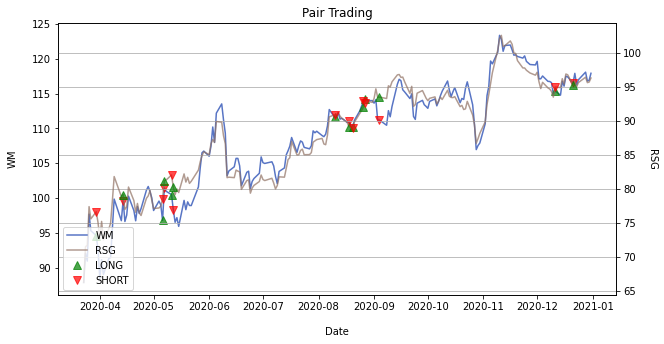

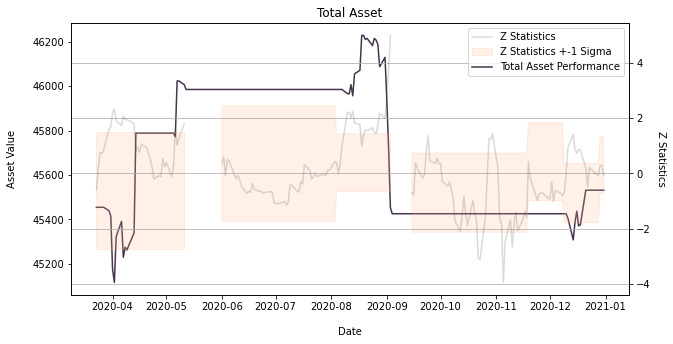

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


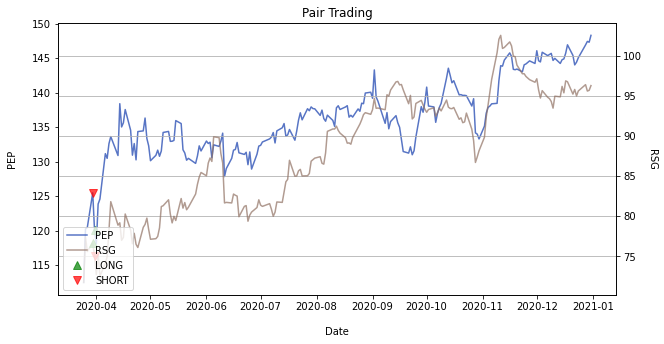

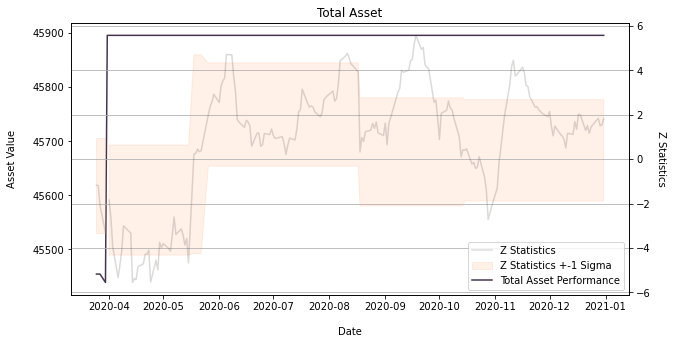

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


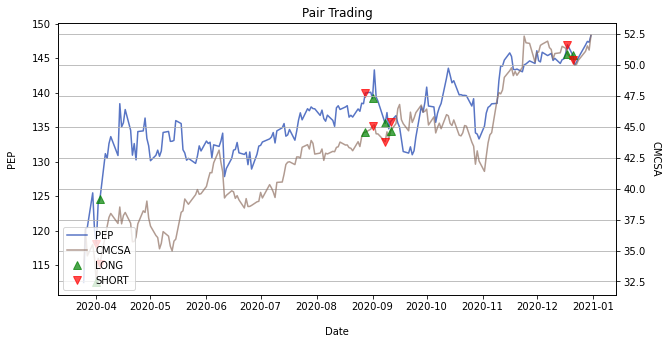

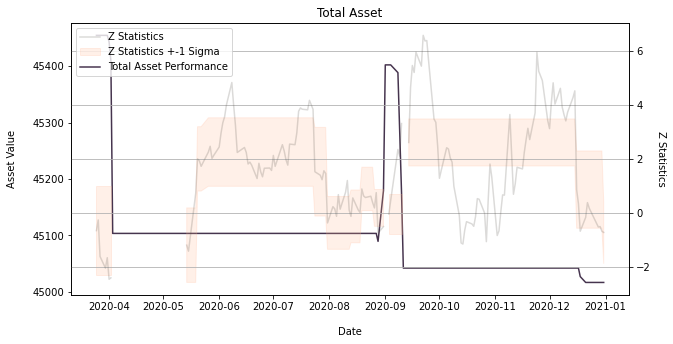

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


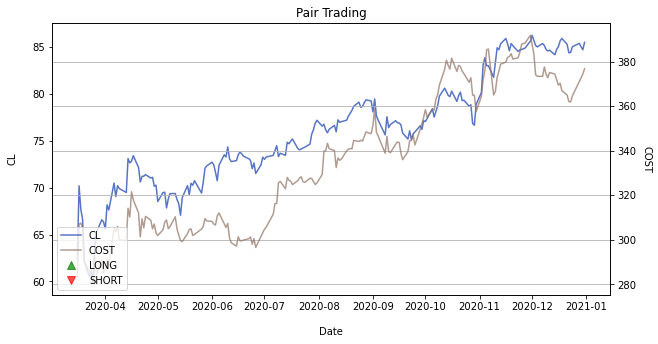

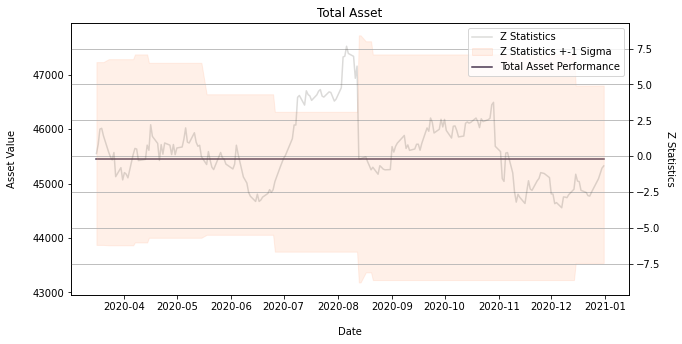

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


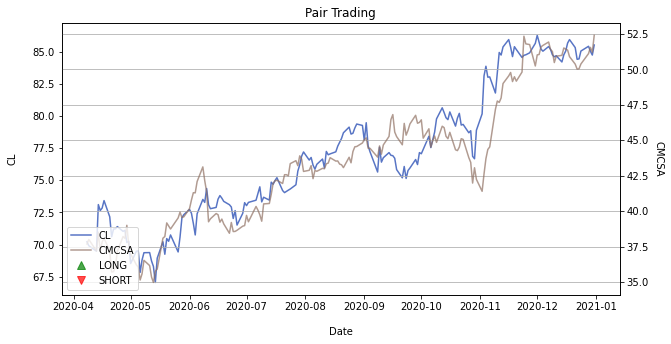

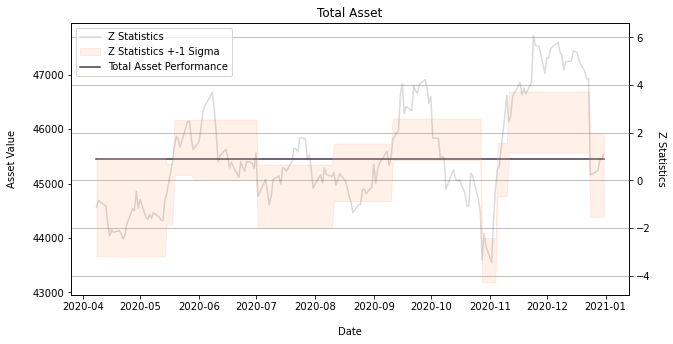

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


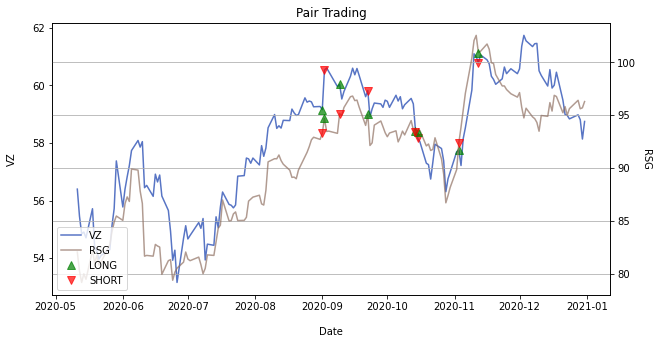

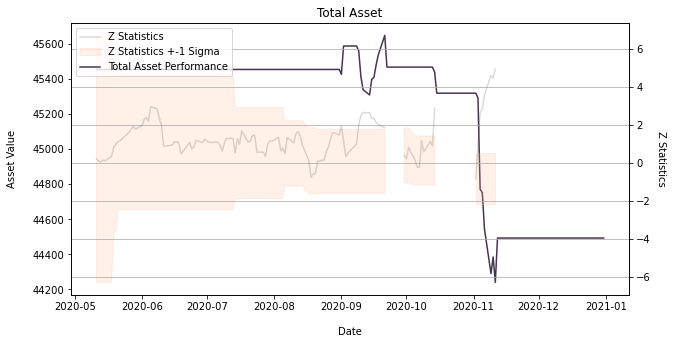

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


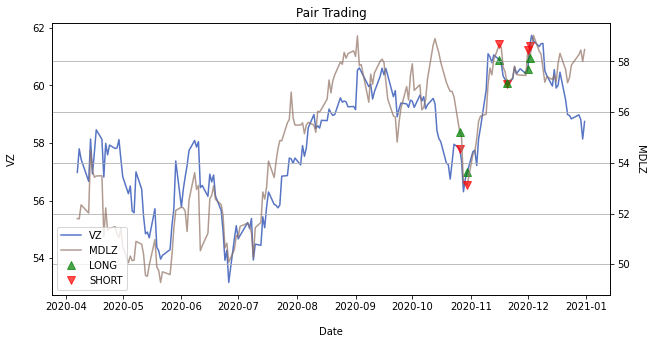

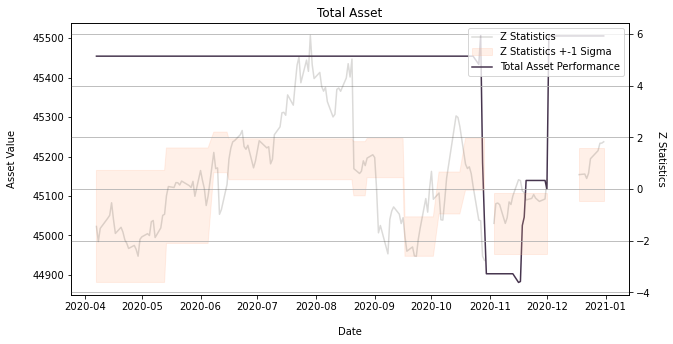

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


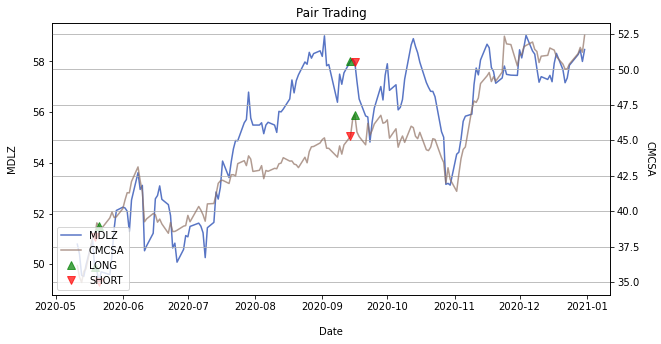

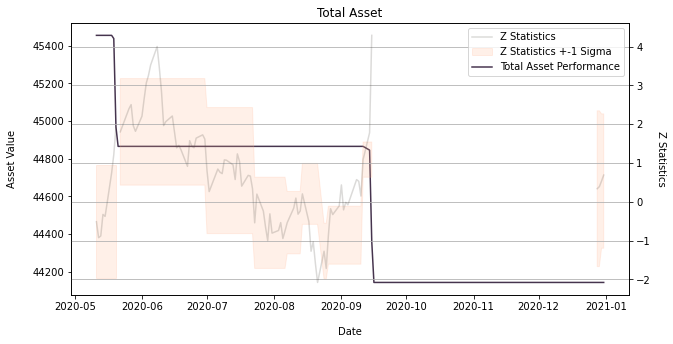

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


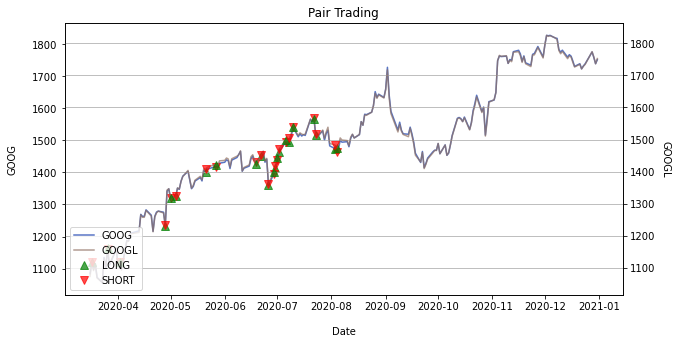

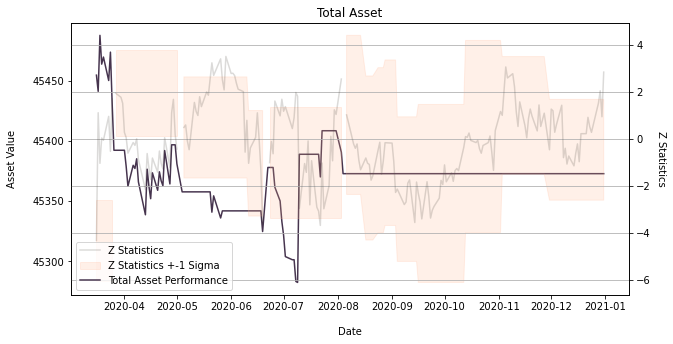

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


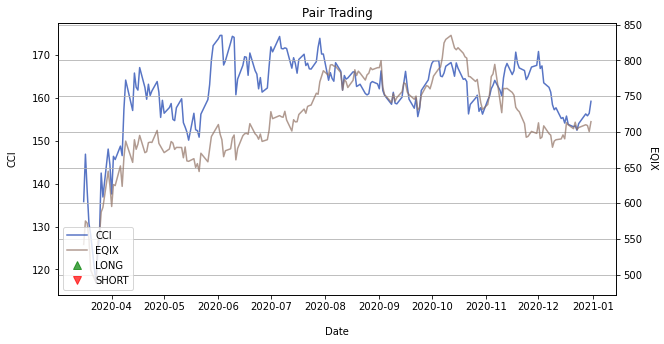

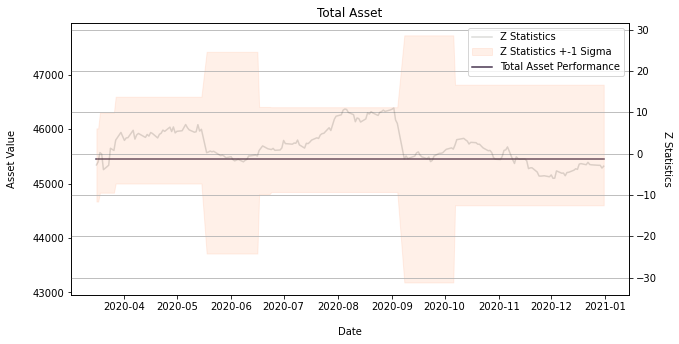

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


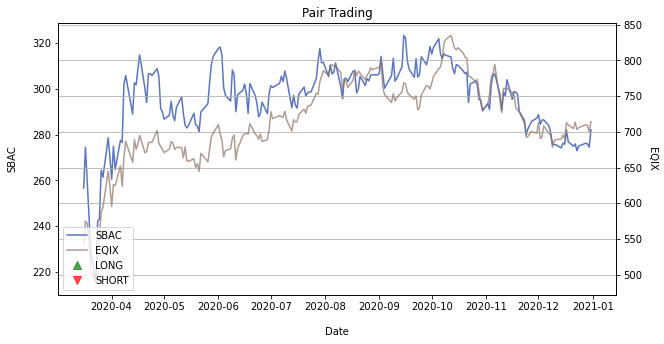

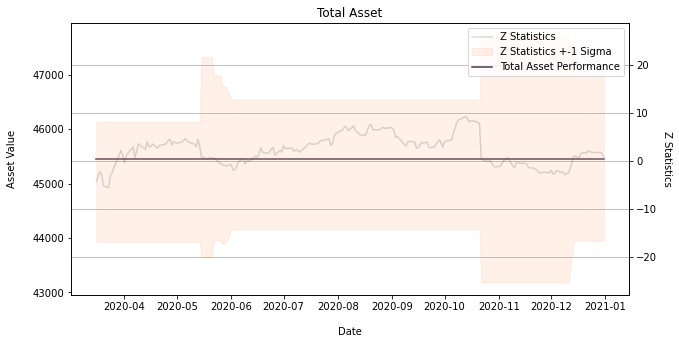

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


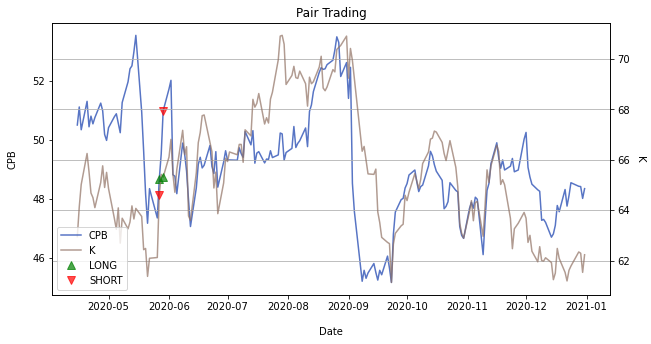

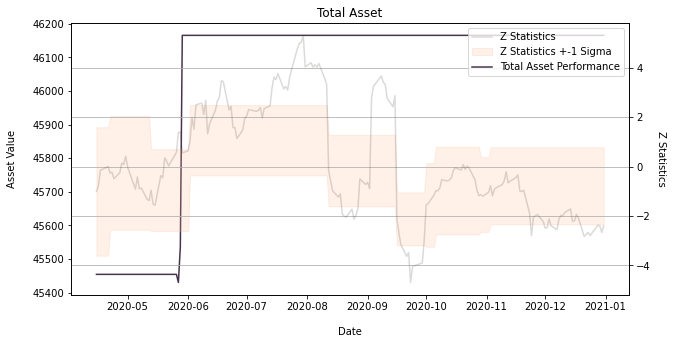

No handles with labels found to put in legend.



PERFORMANCE STATISTICS FOR MARKET NEUTRAL
Daily annualized sharpe: 0.3058784649336497
Average annual returns: 0.1975525681725912%
Total returns: 0.12856595706470225%
2020-05-11    0.004662
2020-05-12    0.004640
2020-05-13    0.004640
2020-05-14    0.004640
2020-05-15    0.004640
                ...   
2020-12-24    0.001279
2020-12-28    0.001303
2020-12-29    0.001315
2020-12-30    0.001259
2020-12-31    0.001286
Name: daily_pnl, Length: 164, dtype: float64
Max drawdown: -0.45990474746018883%


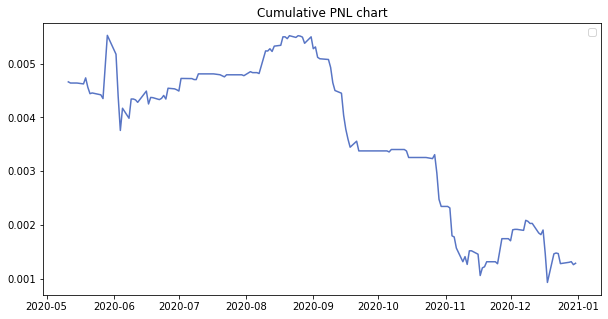

In [25]:
if __name__ == '__main__':
    main()

# 4. Backtesting

## 4.1 Refine Selected Pairs 

### 4.1.1 Select Most Correlated Pairs

> Using refiend pairs with backtesting period from 2020.1.1 to 2021.1.1

In [26]:
pairs_top = [('ED', 'NI'),
 ('SO', 'EXC'),
 ('CMS', 'LNT'),
 ('PEP', 'CMCSA')
]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


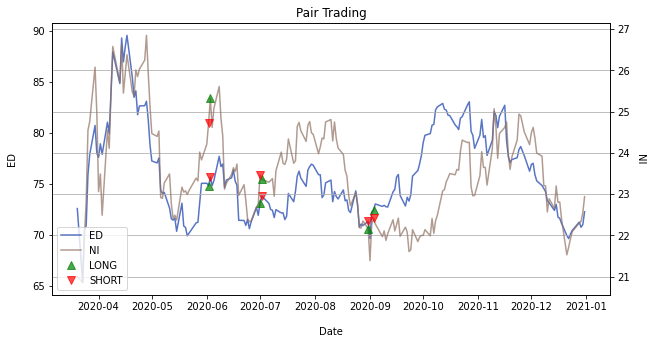

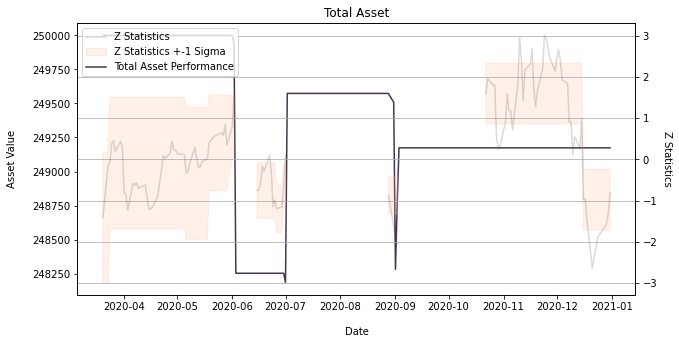

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


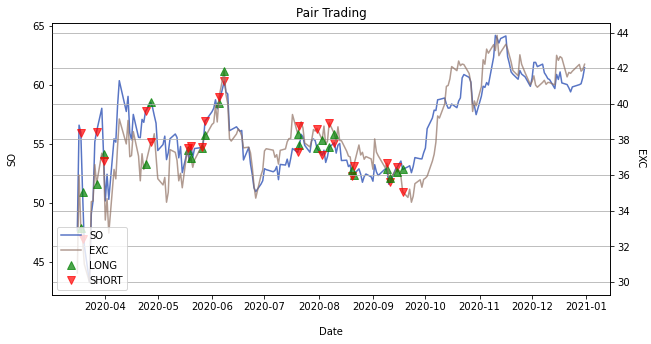

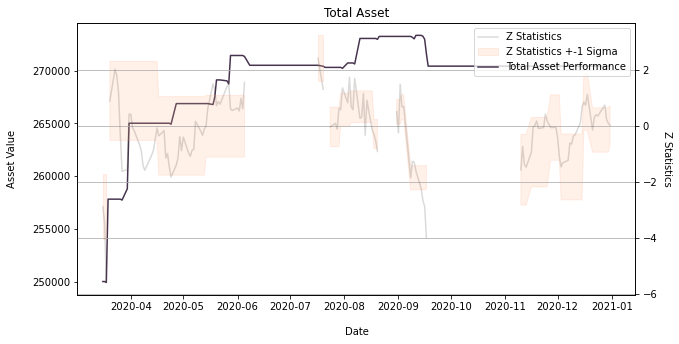

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


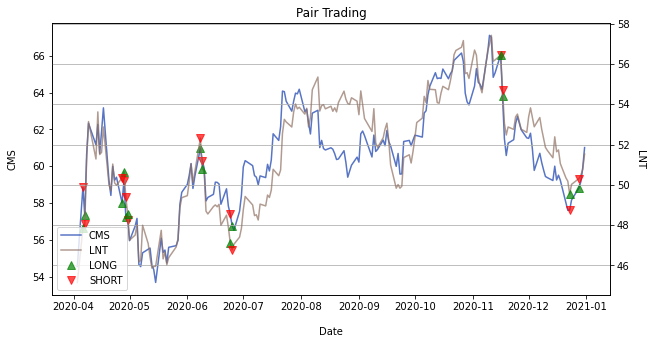

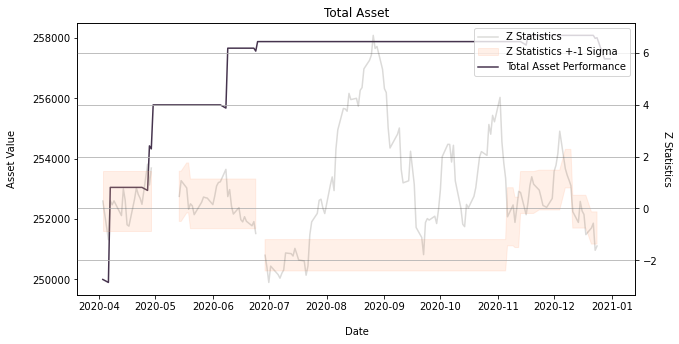

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


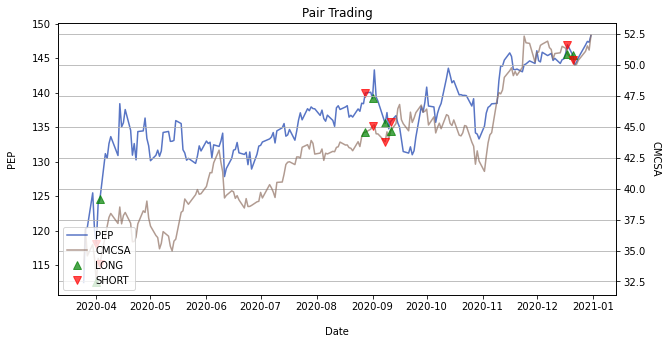

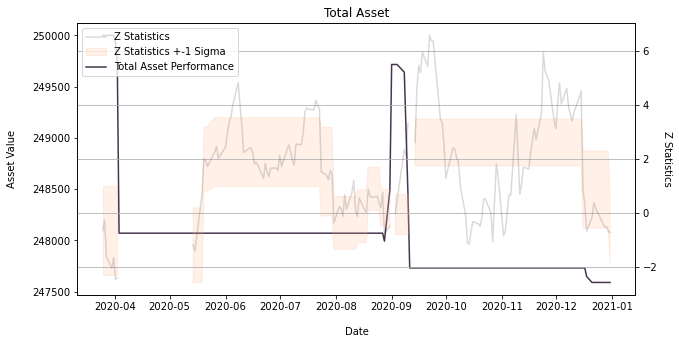

No handles with labels found to put in legend.



PERFORMANCE STATISTICS FOR MARKET NEUTRAL
Daily annualized sharpe: 1.9166694242843836
Average annual returns: 3.265490442778131%
Total returns: 2.4491178320835956%
2020-04-03    0.013079
2020-04-06    0.012980
2020-04-07    0.016129
2020-04-08    0.016129
2020-04-09    0.016129
                ...   
2020-12-24    0.025191
2020-12-28    0.024491
2020-12-29    0.024491
2020-12-30    0.024491
2020-12-31    0.024491
Name: daily_pnl, Length: 189, dtype: float64
Max drawdown: -0.5516046053220859%


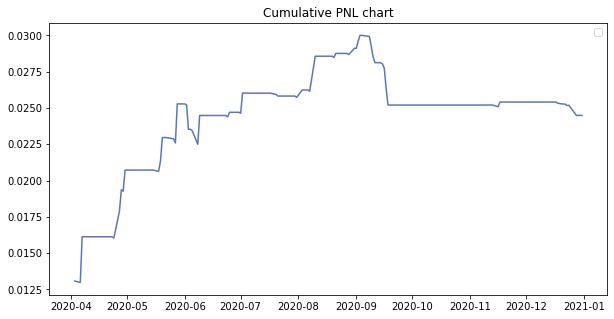

In [27]:
def main():
    stdate='2020-01-01'
    eddate='2021-01-01'
    total_capital = 1000000
    capital = total_capital/(len(pairs_top)*2)
    portfolio_details_list=[]
    for pair in pairs_top:
        
        pair_portfolio = singelPair(list(pair),capital,stdate,eddate)
        portfolio_details_list.append(pair_portfolio["total asset"])

    overall_pnl = pd.concat(portfolio_details_list, axis=1,join="inner")
    overall_pnl['pnl'] = overall_pnl.sum(axis=1)-total_capital

    overall_pnl['daily_pnl'] = (overall_pnl['pnl']-overall_pnl['pnl'].shift(periods=1, fill_value=overall_pnl['pnl'][0]/total_capital))/total_capital
    overall_pnl['daily_pnl'].iloc[0] =(overall_pnl['pnl'].iloc[0])/total_capital
    
    pnlPerformance(overall_pnl['daily_pnl'], "MARKET NEUTRAL")

if __name__ == '__main__':
    main()

In [ ]:
pairs_top_1 = [
 ('PEP', 'CMCSA')
]

## 4.2 Change Back Testing Period 

###  4.2.1 Back Test 2018.1.1 - 2021.1.1 

> Using refiend pairs with signal generation window bandwidth = 50

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


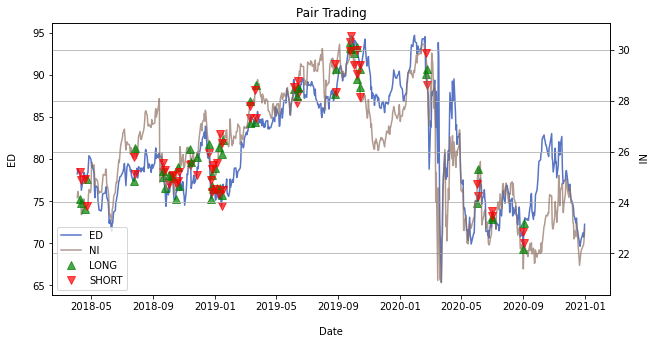

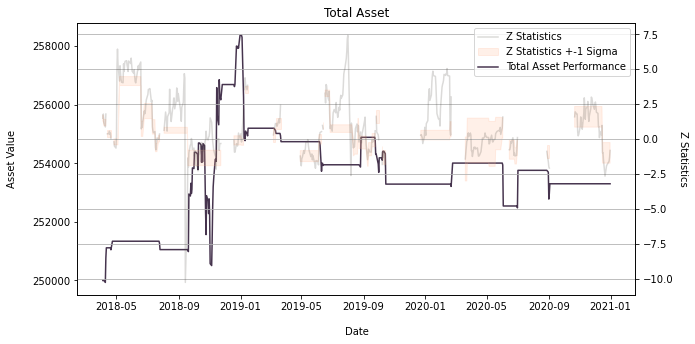

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


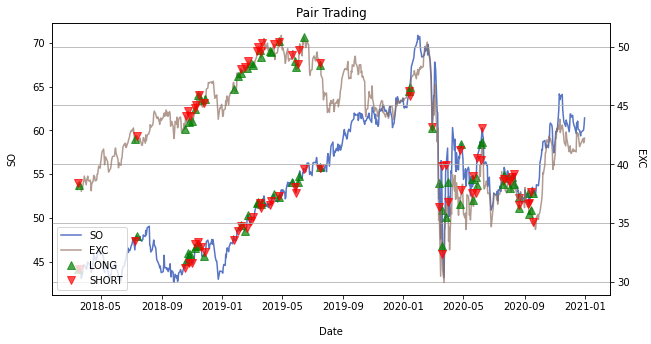

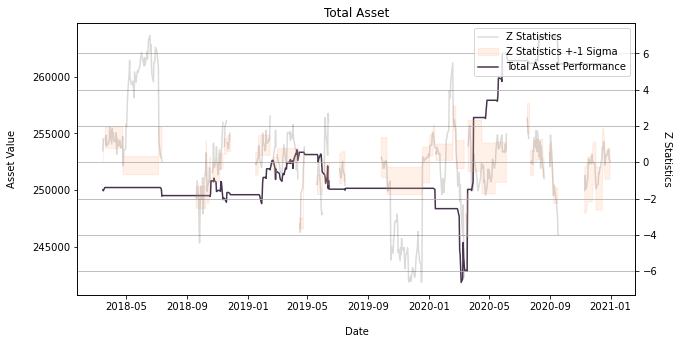

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


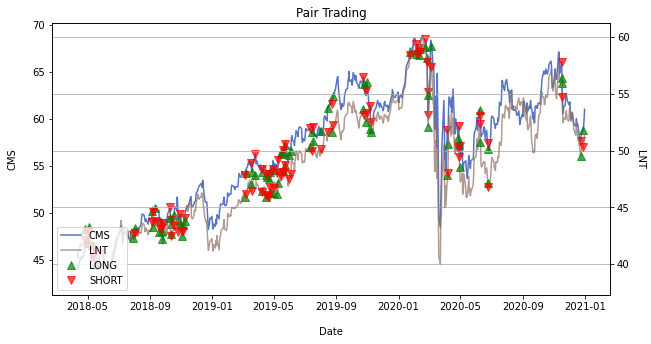

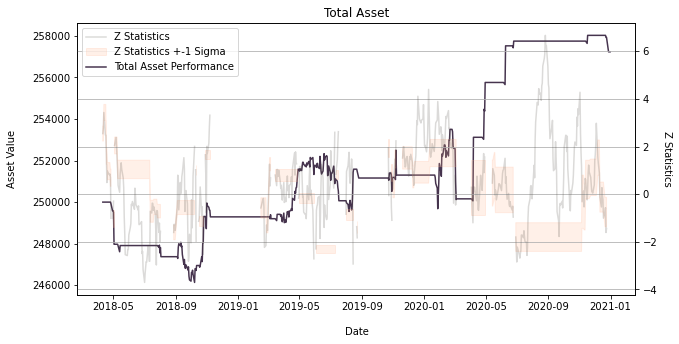

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


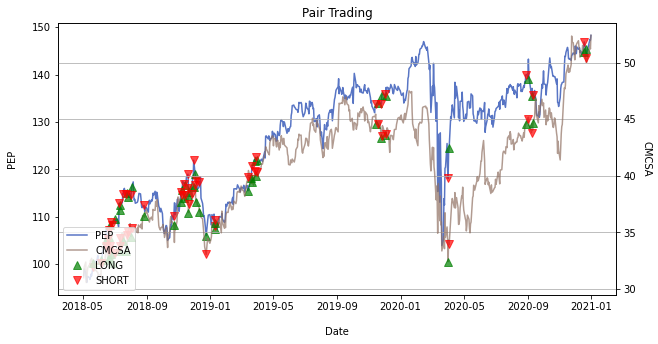

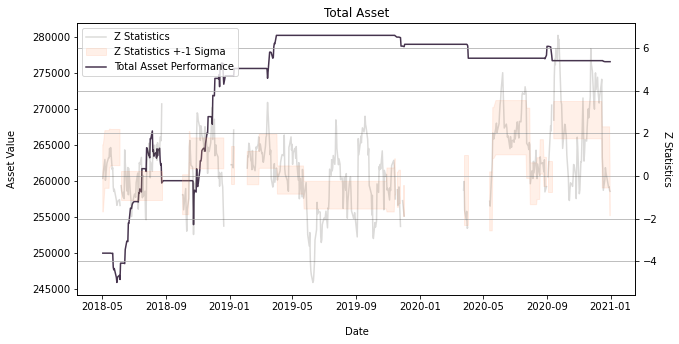

No handles with labels found to put in legend.



PERFORMANCE STATISTICS FOR MARKET NEUTRAL
Daily annualized sharpe: 1.3371534440969963
Average annual returns: 1.8078275261261576%
Total returns: 4.820873403003091%
2018-05-03   -0.000477
2018-05-04   -0.000477
2018-05-07   -0.000477
2018-05-08   -0.000477
2018-05-09   -0.000477
                ...   
2020-12-24    0.048903
2020-12-28    0.048209
2020-12-29    0.048209
2020-12-30    0.048209
2020-12-31    0.048209
Name: daily_pnl, Length: 672, dtype: float64
Max drawdown: -1.5311654001497204%


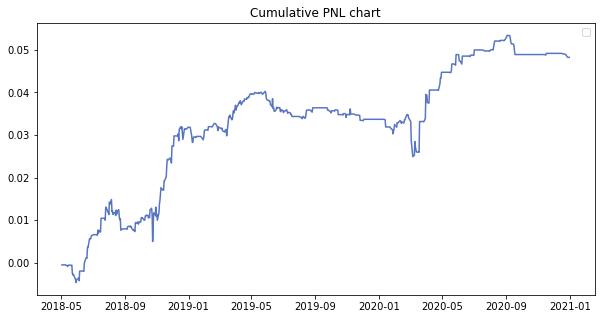

In [31]:
def main():
    stdate='2018-01-01'
    eddate='2021-01-01'
    total_capital = 1000000
    capital = total_capital/(len(pairs_top)*2)
    portfolio_details_list=[]
    for pair in pairs_top:
        pair_portfolio = singelPair(list(pair),capital,stdate,eddate)
        portfolio_details_list.append(pair_portfolio["total asset"])

    overall_pnl = pd.concat(portfolio_details_list, axis=1,join="inner")
    overall_pnl['pnl'] = overall_pnl.sum(axis=1)-total_capital
    overall_pnl['daily_pnl'] = (overall_pnl['pnl']-overall_pnl['pnl'].shift(periods=1, fill_value=overall_pnl['pnl'][0]/total_capital))/total_capital
    pnlPerformance(overall_pnl['daily_pnl'], "MARKET NEUTRAL")

    
if __name__ == '__main__':
    main()

### 4.2.2 Back Test Period 2016.1.1 - 2021.1.1 

> Using refiend pairs with signal generation window bandwidth = 50

In [32]:
def main():
    stdate='2016-01-01'
    eddate='2021-01-01'
    total_capital = 1000000
    capital = total_capital/(len(pairs_top)*2)
    portfolio_details_list=[]
    for pair in pairs_top:
        
        pair_portfolio = singelPair(list(pair),capital,stdate,eddate)
        portfolio_details_list.append(pair_portfolio["total asset"])

    overall_pnl = pd.concat(portfolio_details_list, axis=1,join="inner")
    overall_pnl['pnl'] = overall_pnl.sum(axis=1)-total_capital
    overall_pnl['daily_pnl'] = (overall_pnl['pnl']-overall_pnl['pnl'].shift(periods=1, fill_value=overall_pnl['pnl'][0]/total_capital))/total_capital
    overall_pnl.to_csv("overall_portfolio.csv")
    pnlPerformance(overall_pnl['daily_pnl'], "MARKET NEUTRAL")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


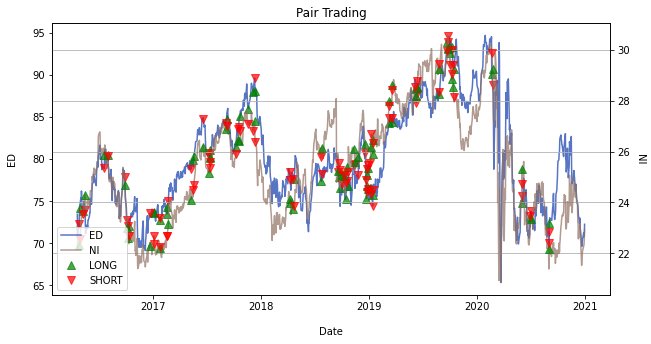

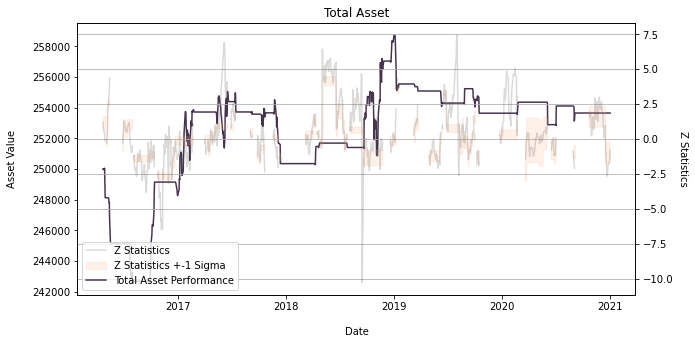

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


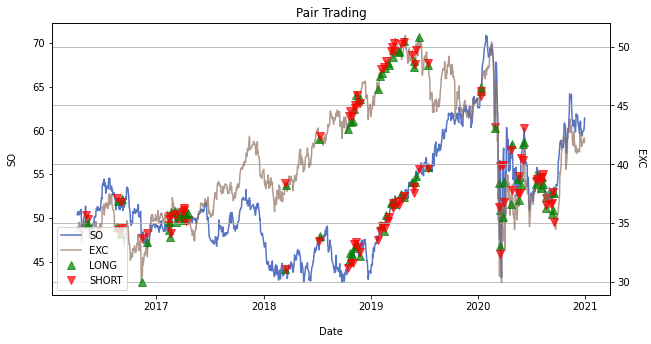

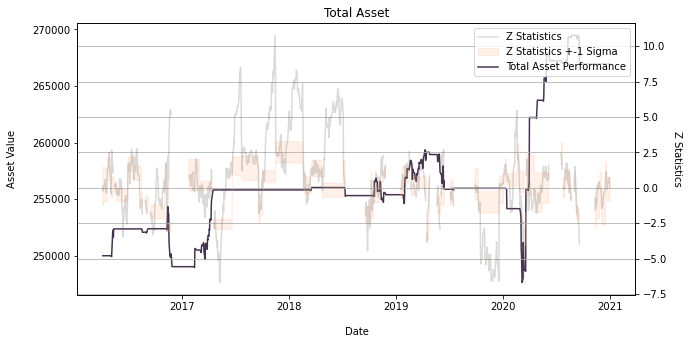

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


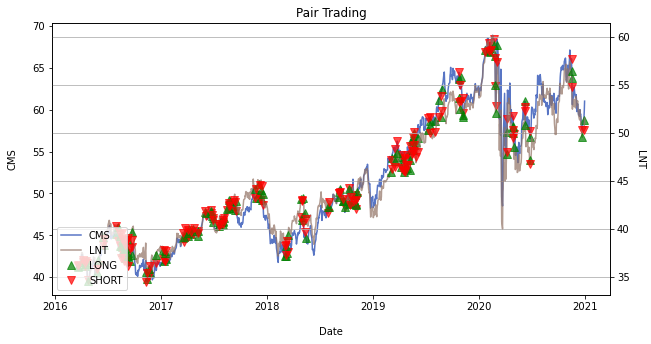

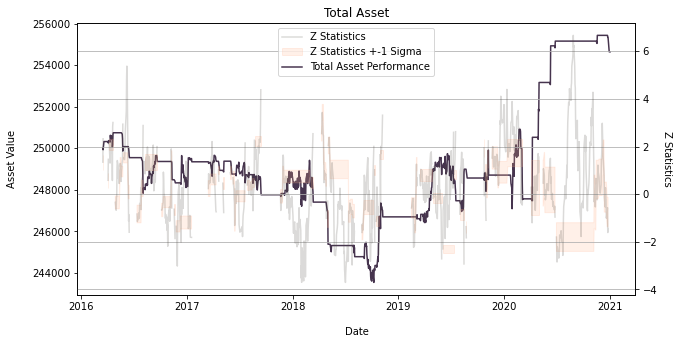

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


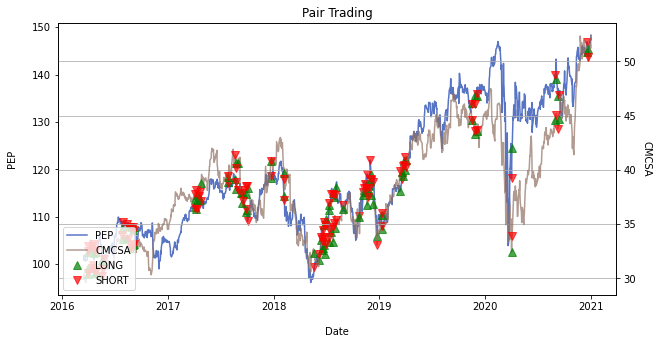

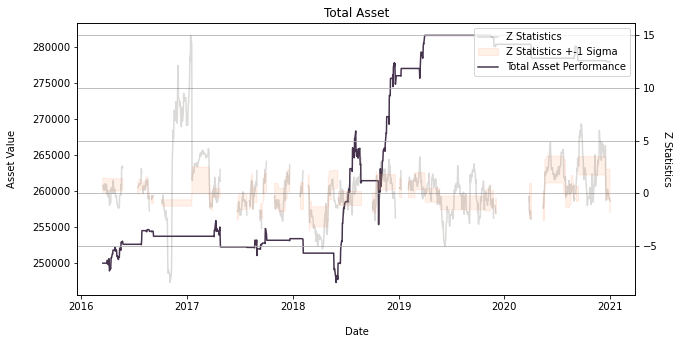

No handles with labels found to put in legend.



PERFORMANCE STATISTICS FOR MARKET NEUTRAL
Daily annualized sharpe: 0.9786759323279358
Average annual returns: 1.1307710640212238%
Total returns: 5.3173163129569465%
2016-04-20    0.001980
2016-04-21    0.002458
2016-04-22    0.002548
2016-04-25    0.002430
2016-04-26    0.002771
                ...   
2020-12-24    0.053868
2020-12-28    0.053173
2020-12-29    0.053173
2020-12-30    0.053173
2020-12-31    0.053173
Name: daily_pnl, Length: 1185, dtype: float64
Max drawdown: -1.531165400149721%


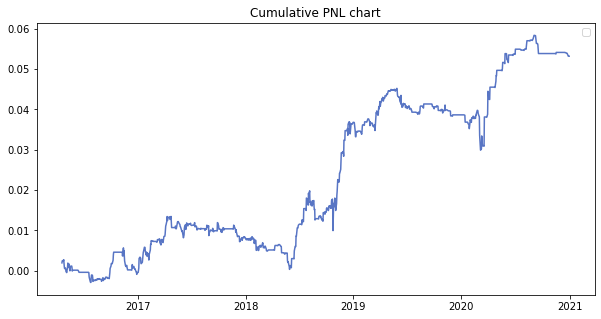

In [33]:
if __name__ == '__main__':
    main()

## 4.3 Change Signal Generation Window from 50 to 250 

> Using refined pairs with 2018-2021 as backtesting period

In [34]:
def signal_generation(asset1,asset2,method,vader_Buy, vader_Sell, rating_score, bandwidth=250):
    
    signals=pd.DataFrame()
    signals['asset1']=asset1['Close']
    signals['asset2']=asset2['Close']
    
    #signals only imply holding
    signals['signals1']=0    
    signals['signals2']=0
    
    #initialize
    prev_status=False
    signals['z']=np.nan
    signals['z upper limit']=np.nan
    signals['z lower limit']=np.nan
    signals['fitted']=np.nan    
    signals['residual']=np.nan
    signals["sentiment_buy"] = np.where(signals.index.isin(vader_Buy), 1, 0)
    signals["sentiment_sell"] = np.where(signals.index.isin(vader_Sell),-1, 0)
    signals = signals.merge(rating_score, left_index=True, right_index=True)
    
    #signal processing
    for i in range(bandwidth,len(signals)):
        
        #cointegration test
        coint_status,model=EG_method(signals['asset1'].iloc[i-bandwidth:i],
                                  signals['asset2'].iloc[i-bandwidth:i])
                
        #cointegration breaks
        #clear existing positions
        if prev_status and not coint_status:           
            if signals.at[signals.index[i-1],'signals1']!=0:
                signals.at[signals.index[i],'signals1']=0
                signals.at[signals.index[i],'signals2']=0
                signals['z'].iloc[i:]=np.nan
                signals['z upper limit'].iloc[i:]=np.nan
                signals['z lower limit'].iloc[i:]=np.nan
                signals['fitted'].iloc[i:]=np.nan    
                signals['residual'].iloc[i:]=np.nan
#                 signals["sentiment_buy"] = np.nan
#                 signals["sentiment_sell"] = np.nan
        
        #cointegration starts
        #set the trigger conditions
        #this is no forward bias
        #just to minimize the calculation done in pandas
        if not prev_status and coint_status:
            
            #predict the price to compute the residual       
            signals['fitted'].iloc[i:]=model.predict(sm.add_constant(signals['asset1'].iloc[i:], prepend=True, has_constant='add'))
            signals['residual'].iloc[i:]=signals['asset2'].iloc[i:]-signals['fitted'].iloc[i:]
            
            #normalize the residual to get z stat
            #z should be a white noise following N(0,1)
            signals['z'].iloc[i:]=(signals['residual'].iloc[i:]-np.mean(model.resid))/np.std(model.resid)
                        
            #create thresholds
            #conventionally one sigma is the threshold
            #two sigma reaches 95% which is relatively difficult to trigger
            signals['z upper limit'].iloc[i:]=signals['z'].iloc[i]+np.std(model.resid)
            signals['z lower limit'].iloc[i:]=signals['z'].iloc[i]-np.std(model.resid)

     
        if coint_status and signals['z'].iloc[i]>signals['z upper limit'].iloc[i]:
             signals.at[signals.index[i],'signals1']=1
        if coint_status and signals['z'].iloc[i]<signals['z lower limit'].iloc[i]:
             signals.at[signals.index[i],'signals1']=-1 
        prev_status=coint_status    
    
    #signals only imply holding
    #we take the first order difference to obtain the execution signal
    signals['positions1']=signals['signals1'].diff()
    
    #only need to generate trading signal of one asset
    #the other one should be the opposite direction
    signals['signals2']=-signals['signals1']
    signals['positions2']=signals['signals2'].diff()   
    
    return signals

In [35]:
def main():
    stdate='2018-01-01'
    eddate='2021-01-01'
    total_capital = 1000000
    capital = total_capital/(len(pairs_top)*2)
    portfolio_details_list=[]
    for pair in pairs_top:
        
        pair_portfolio = singelPair(list(pair),capital,stdate,eddate)
        portfolio_details_list.append(pair_portfolio["total asset"])

    overall_pnl = pd.concat(portfolio_details_list, axis=1,join="inner")
    overall_pnl['pnl'] = overall_pnl.sum(axis=1)-total_capital

    overall_pnl['daily_pnl'] = (overall_pnl['pnl']-overall_pnl['pnl'].shift(periods=1, fill_value=overall_pnl['pnl'][0]/total_capital))/total_capital

    pnlPerformance(overall_pnl['daily_pnl'], "MARKET NEUTRAL")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


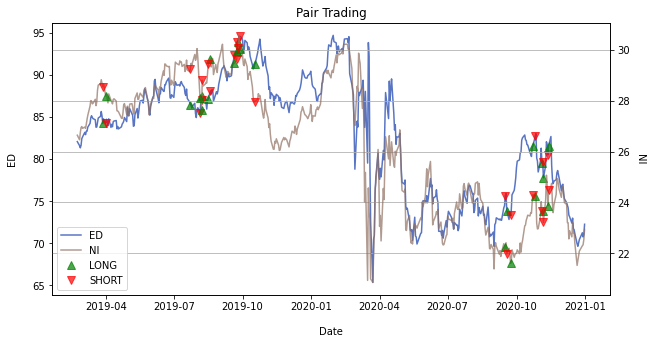

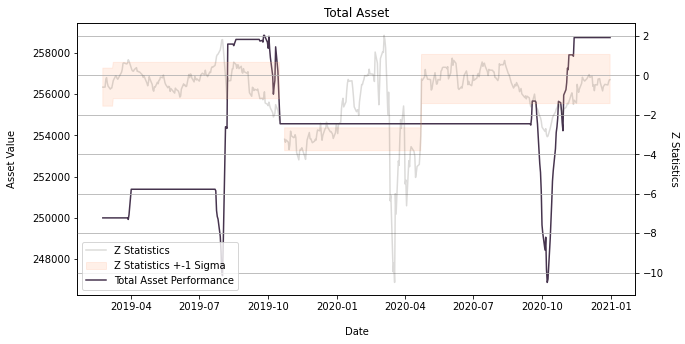

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


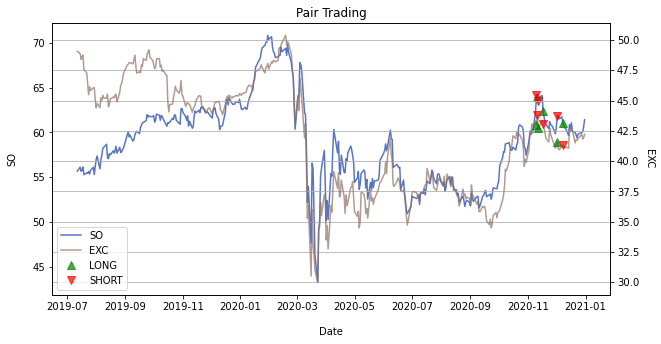

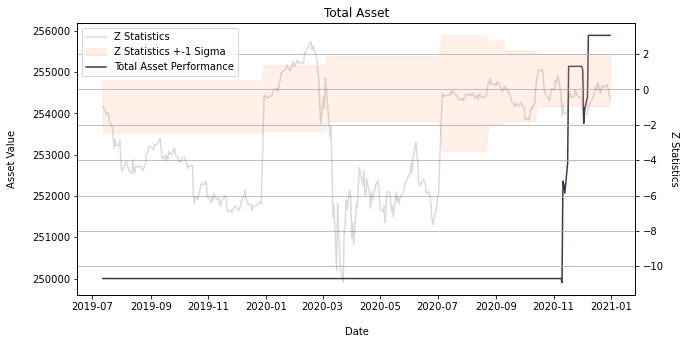

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


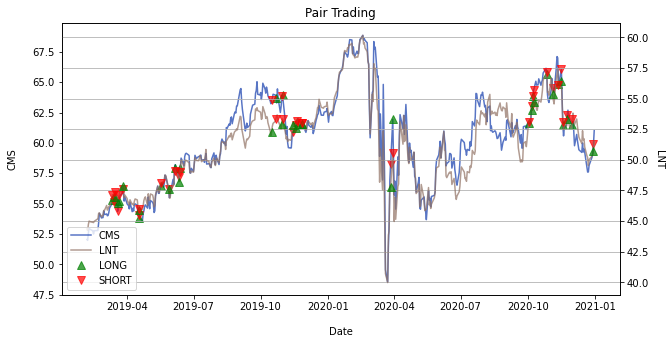

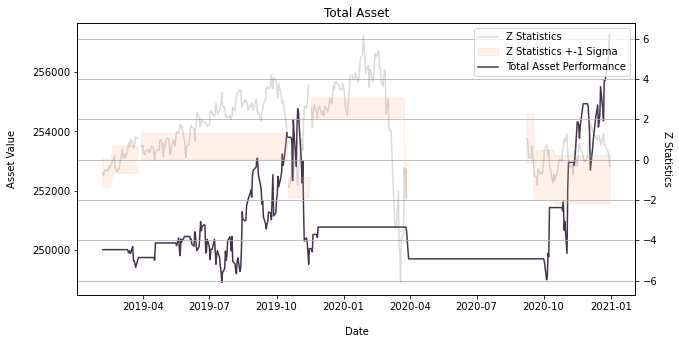

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


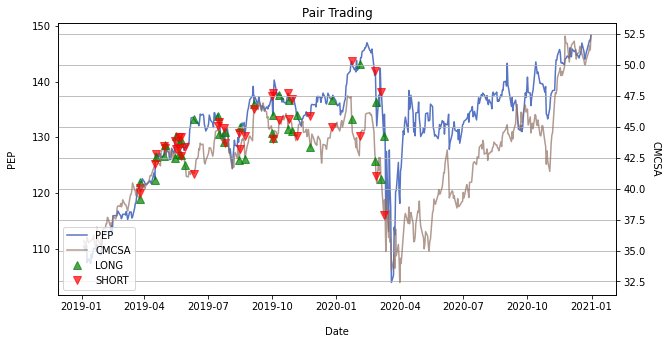

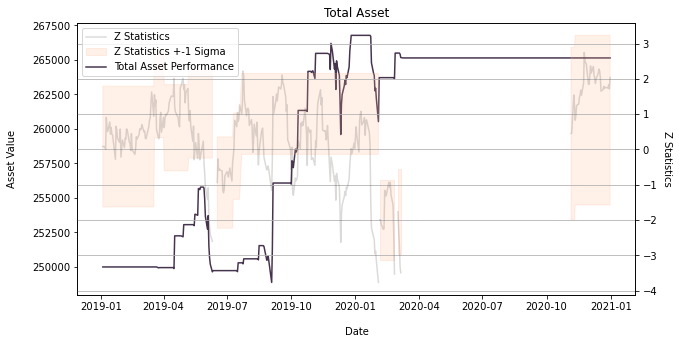

No handles with labels found to put in legend.



PERFORMANCE STATISTICS FOR MARKET NEUTRAL
Daily annualized sharpe: 1.8004198470581971
Average annual returns: 2.5016757519260033%
Total returns: 3.7028772042396794%
2019-07-12    0.001094
2019-07-15    0.000855
2019-07-16    0.000484
2019-07-17    0.000950
2019-07-18    0.000580
                ...   
2020-12-24    0.035490
2020-12-28    0.036085
2020-12-29    0.036350
2020-12-30    0.037029
2020-12-31    0.037029
Name: daily_pnl, Length: 373, dtype: float64
Max drawdown: -1.1652998517474167%


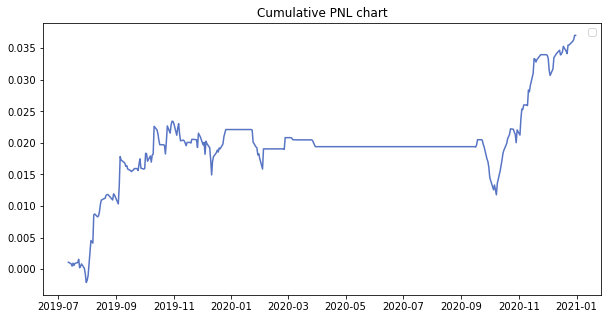

In [36]:
if __name__ == '__main__':
    main()

## 4.4 Adding News Sentiment / Analyst Scorig / Attention Analysis

### 4.4.1 Without any addtional analysis for 2020.07.01-2021.07.01

In [69]:
pairs_top = [
 ('SO', 'EXC')
]

In [70]:
def main():
    stdate='2020-07-01'
    eddate='2021-07-01'
    total_capital = 1000000
    capital = total_capital/(len(pairs_top)*2)
    portfolio_details_list=[]
    for pair in pairs_top:
        
        pair_portfolio = singelPair(list(pair),capital,stdate,eddate)
        portfolio_details_list.append(pair_portfolio["total asset"])

    overall_pnl = pd.concat(portfolio_details_list, axis=1,join="inner")
    overall_pnl['pnl'] = overall_pnl.sum(axis=1)-total_capital
    overall_pnl['daily_pnl'] = (overall_pnl['pnl']-overall_pnl['pnl'].shift(periods=1, fill_value=overall_pnl['pnl'][0]/total_capital))/total_capital

    pnlPerformance(overall_pnl['daily_pnl'], "MARKET NEUTRAL")

In [71]:
def signal_generation(asset1,asset2,method,vader_Buy, vader_Sell, rating_score, bandwidth=50):
    
    signals=pd.DataFrame()
    signals['asset1']=asset1['Close']
    signals['asset2']=asset2['Close']
    
    #signals only imply holding
    signals['signals1']=0    
    signals['signals2']=0
    
    #initialize
    prev_status=False
    signals['z']=np.nan
    signals['z upper limit']=np.nan
    signals['z lower limit']=np.nan
    signals['fitted']=np.nan    
    signals['residual']=np.nan
    signals["sentiment_buy"] = np.where(signals.index.isin(vader_Buy), 1, 0)
    signals["sentiment_sell"] = np.where(signals.index.isin(vader_Sell),-1, 0)
    signals = signals.merge(rating_score, left_index=True, right_index=True)
    
    #signal processing
    for i in range(bandwidth,len(signals)):
        
        #cointegration test
        coint_status,model=EG_method(signals['asset1'].iloc[i-bandwidth:i],
                                  signals['asset2'].iloc[i-bandwidth:i])
                
        #cointegration breaks
        #clear existing positions
        if prev_status and not coint_status:           
            if signals.at[signals.index[i-1],'signals1']!=0:
                signals.at[signals.index[i],'signals1']=0
                signals.at[signals.index[i],'signals2']=0
                signals['z'].iloc[i:]=np.nan
                signals['z upper limit'].iloc[i:]=np.nan
                signals['z lower limit'].iloc[i:]=np.nan
                signals['fitted'].iloc[i:]=np.nan    
                signals['residual'].iloc[i:]=np.nan

        #cointegration starts
        #set the trigger conditions
        #this is no forward bias
        #just to minimize the calculation done in pandas
        if not prev_status and coint_status:
            
            #predict the price to compute the residual       
            signals['fitted'].iloc[i:]=model.predict(sm.add_constant(signals['asset1'].iloc[i:], prepend=True, has_constant='add'))
            signals['residual'].iloc[i:]=signals['asset2'].iloc[i:]-signals['fitted'].iloc[i:]
            
            #normalize the residual to get z stat
            #z should be a white noise following N(0,1)
            signals['z'].iloc[i:]=(signals['residual'].iloc[i:]-np.mean(model.resid))/np.std(model.resid)
                        
            #create thresholds
            #conventionally one sigma is the threshold
            #two sigma reaches 95% which is relatively difficult to trigger
            signals['z upper limit'].iloc[i:]=signals['z'].iloc[i]+np.std(model.resid)
            signals['z lower limit'].iloc[i:]=signals['z'].iloc[i]-np.std(model.resid)


#################################### No News Headline Sentiment #######################################
        if coint_status and signals['z'].iloc[i]>signals['z upper limit'].iloc[i]:
             signals.at[signals.index[i],'signals1']=1
        if coint_status and signals['z'].iloc[i]<signals['z lower limit'].iloc[i]:
             signals.at[signals.index[i],'signals1']=-1 
        prev_status=coint_status    
    
    #signals only imply holding
    #we take the first order difference to obtain the execution signal
    signals['positions1']=signals['signals1'].diff()
    
    #only need to generate trading signal of one asset
    #the other one should be the opposite direction
    signals['signals2']=-signals['signals1']
    signals['positions2']=signals['signals2'].diff()   
    
    return signals


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


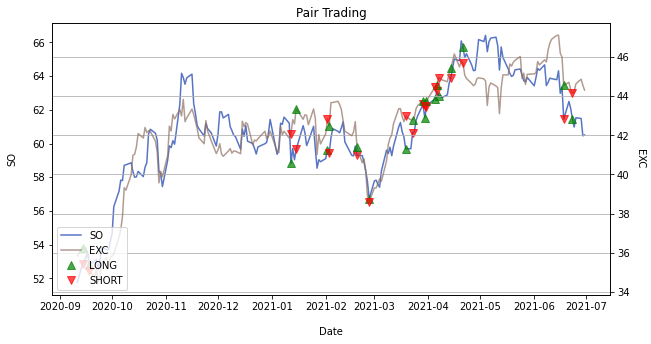

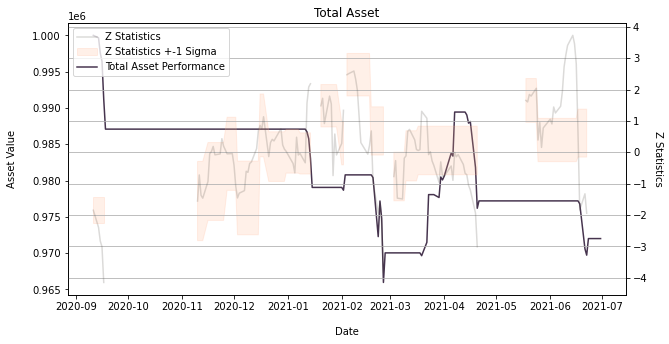

No handles with labels found to put in legend.



PERFORMANCE STATISTICS FOR MARKET NEUTRAL
Daily annualized sharpe: -1.4175475799505195
Average annual returns: -3.4928057412173446%
Total returns: -2.7997887290710457%
2020-09-11    0.000000
2020-09-14   -0.000335
2020-09-15   -0.002420
2020-09-16   -0.003572
2020-09-17   -0.008805
                ...   
2021-06-24   -0.027998
2021-06-25   -0.027998
2021-06-28   -0.027998
2021-06-29   -0.027998
2021-06-30   -0.027998
Name: daily_pnl, Length: 202, dtype: float64
Max drawdown: -3.4041389776273743%


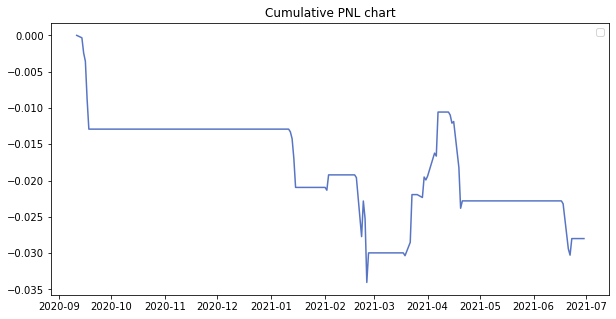

In [72]:
if __name__ == '__main__':
    main()

### 4.4.2 With News Sentiment Analysis for 2020.07.01-2021.07.01 (News Headlines)

In [73]:
def signal_generation(asset1,asset2,method,vader_Buy, vader_Sell, rating_score, bandwidth=50):
    
    signals=pd.DataFrame()
    signals['asset1']=asset1['Close']
    signals['asset2']=asset2['Close']
    
    #signals only imply holding
    signals['signals1']=0    
    signals['signals2']=0
    
    #initialize
    prev_status=False
    signals['z']=np.nan
    signals['z upper limit']=np.nan
    signals['z lower limit']=np.nan
    signals['fitted']=np.nan    
    signals['residual']=np.nan
    signals["sentiment_buy"] = np.where(signals.index.isin(vader_Buy), 1, 0)
    signals["sentiment_sell"] = np.where(signals.index.isin(vader_Sell),-1, 0)
    signals = signals.merge(rating_score, left_index=True, right_index=True)
    
    #signal processing
    for i in range(bandwidth,len(signals)):
        
        #cointegration test
        coint_status,model=EG_method(signals['asset1'].iloc[i-bandwidth:i],
                                  signals['asset2'].iloc[i-bandwidth:i])
                
        #cointegration breaks
        #clear existing positions
        if prev_status and not coint_status:           
            if signals.at[signals.index[i-1],'signals1']!=0:
                signals.at[signals.index[i],'signals1']=0
                signals.at[signals.index[i],'signals2']=0
                signals['z'].iloc[i:]=np.nan
                signals['z upper limit'].iloc[i:]=np.nan
                signals['z lower limit'].iloc[i:]=np.nan
                signals['fitted'].iloc[i:]=np.nan    
                signals['residual'].iloc[i:]=np.nan
        
        #cointegration starts
        #set the trigger conditions
        if not prev_status and coint_status:
            
            #predict the price to compute the residual       
#             signals['fitted'].iloc[i:]=model.predict(sm.add_constant(signals['asset1'].iloc[i:]))
            signals['fitted'].iloc[i:]=model.predict(sm.add_constant(signals['asset1'].iloc[i:], prepend=True, has_constant='add'))
            signals['residual'].iloc[i:]=signals['asset2'].iloc[i:]-signals['fitted'].iloc[i:]
            
            #normalize the residual to get z stat
            #z should be a white noise following N(0,1)
            signals['z'].iloc[i:]=(signals['residual'].iloc[i:]-np.mean(model.resid))/np.std(model.resid)
                        
            #create thresholds
            #conventionally one sigma is the threshold
            #two sigma reaches 95% which is relatively difficult to trigger
            signals['z upper limit'].iloc[i:]=signals['z'].iloc[i]+np.std(model.resid)
            signals['z lower limit'].iloc[i:]=signals['z'].iloc[i]-np.std(model.resid)


#################################### Attention Sentiment #######################################
        if coint_status and signals['z'].iloc[i]>signals['z upper limit'].iloc[i] and signals["sentiment_buy"].iloc[i] != -1:
             signals.at[signals.index[i],'signals1']=1
        if coint_status and signals['z'].iloc[i]<signals['z lower limit'].iloc[i] and signals["sentiment_sell"].iloc[i]!= 1:
             signals.at[signals.index[i],'signals1']=-1 
        prev_status=coint_status    
    
    #signals only imply holding
    #we take the first order difference to obtain the execution signal
    signals['positions1']=signals['signals1'].diff()
    
    #only need to generate trading signal of one asset
    #the other one should be the opposite direction
    signals['signals2']=-signals['signals1']
    signals['positions2']=signals['signals2'].diff()   
    
    return signals


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


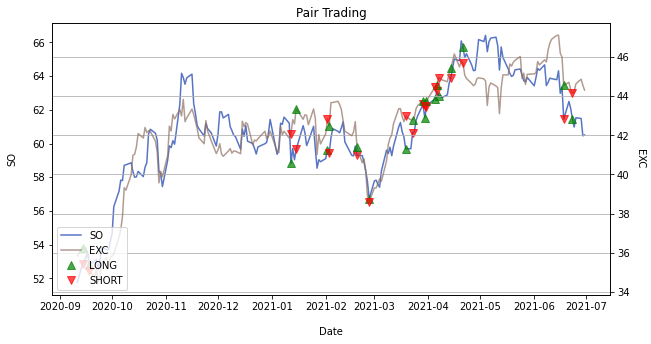

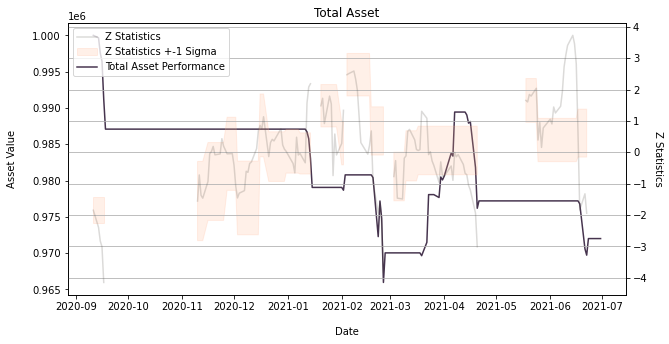

No handles with labels found to put in legend.



PERFORMANCE STATISTICS FOR MARKET NEUTRAL
Daily annualized sharpe: -1.4175475799505195
Average annual returns: -3.4928057412173446%
Total returns: -2.7997887290710457%
2020-09-11    0.000000
2020-09-14   -0.000335
2020-09-15   -0.002420
2020-09-16   -0.003572
2020-09-17   -0.008805
                ...   
2021-06-24   -0.027998
2021-06-25   -0.027998
2021-06-28   -0.027998
2021-06-29   -0.027998
2021-06-30   -0.027998
Name: daily_pnl, Length: 202, dtype: float64
Max drawdown: -3.4041389776273743%


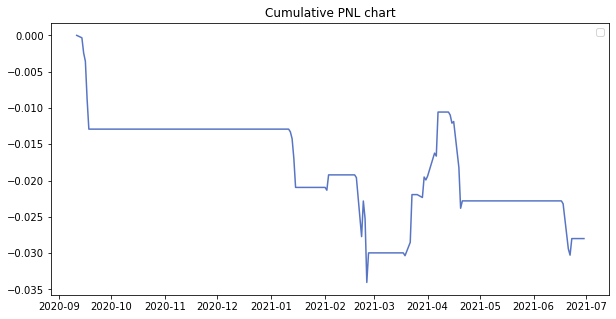

In [74]:
if __name__ == '__main__':
    main()

### 4.4.3 With Analyst Scoring Analysis for 2020.07.01-2021.07.01

In [75]:
def main():
    stdate='2020-07-01'
    eddate='2021-07-01'
    total_capital = 1000000
    capital = total_capital/(len(pairs_top)*2)
    portfolio_details_list=[]
    for pair in pairs_top:
        
        pair_portfolio = singelPair(list(pair),capital,stdate,eddate)
        portfolio_details_list.append(pair_portfolio["total asset"])

    overall_pnl = pd.concat(portfolio_details_list, axis=1,join="inner")
    overall_pnl['pnl'] = overall_pnl.sum(axis=1)-total_capital
    overall_pnl['daily_pnl'] = (overall_pnl['pnl']-overall_pnl['pnl'].shift(periods=1, fill_value=overall_pnl['pnl'][0]/total_capital))/total_capital

    pnlPerformance(overall_pnl['daily_pnl'], "MARKET NEUTRAL")

In [76]:
def getAnalystSentiment(ticker,stdate,eddate):
    start_date = datetime.fromisoformat(stdate)
    end_date = datetime.fromisoformat(eddate)
    delta = timedelta(days=1)
    stock = yf.Ticker(ticker)
    rating_score=[]

    while end_date>=start_date:
        end_date_str = end_date.strftime("%Y-%m-%d")
        end_date_str_mon = datetime.fromisoformat(end_date_str)+ relativedelta(months=-1)
        if stock.recommendations is not None:
            rating_action_stock = stock.recommendations.loc[end_date_str_mon:eddate]
            rating_score.append(rating_action_stock[rating_action_stock["Action"]=="up"]["Firm"].count()*1 + rating_action_stock[rating_action_stock["Action"]=="down"]["Firm"].count()*-1 +   rating_action_stock[rating_action_stock["Action"]=="main"]["Firm"].count()*0)
        else:
            rating_score.append(0)
        
        end_date -= delta
    
    # rating_score
    rating_score_reverse = rating_score[::-1]
    idx = pd.date_range(stdate, eddate, freq="D")
    rating_action_stock_final = pd.DataFrame(data = rating_score_reverse, columns =["score"])
    rating_action_stock_final["Datetime"] = idx
    rating_action_stock_final_reIndex = rating_action_stock_final.set_index("Datetime")

    return rating_action_stock_final_reIndex

In [77]:
def singelPair(pair, capital,stdate,eddate):
    
    ticker1=pair[0]
    ticker2=pair[1]

    #extract data
    asset1=yf.download(ticker1,start=stdate,end=eddate)
    asset2=yf.download(ticker2,start=stdate,end=eddate)  

    #getSentiment
    buy_sentiment, sell_sentiment = getSentiment(ticker1,stdate,eddate)
    rating_score = getAnalystSentiment(ticker1,stdate,eddate)

    #create signals
    signals=signal_generation(asset1,asset2,EG_method,buy_sentiment,sell_sentiment,rating_score)

    #only viz the part where trading signals occur
    if signals['z'].dropna().size !=0:
        ind = signals['z'].dropna().index[0]
    else:ind = signals['z'].dropna()

    #viz positions
    plot(signals[ind:],ticker1,ticker2)    

    #viz portfolio performance
    portfolio_details=portfolio(signals[ind:], capital)
    return  portfolio_details

In [85]:
def signal_generation(asset1,asset2,method,vader_Buy, vader_Sell, rating_score, bandwidth=50):
    
    signals=pd.DataFrame()
    signals['asset1']=asset1['Close']
    signals['asset2']=asset2['Close']
    
    #signals only imply holding
    signals['signals1']=0    
    signals['signals2']=0
    
    #initialize
    prev_status=False
    signals['z']=np.nan
    signals['z upper limit']=np.nan
    signals['z lower limit']=np.nan
    signals['fitted']=np.nan    
    signals['residual']=np.nan
    signals["sentiment_buy"] = np.where(signals.index.isin(vader_Buy), 1, 0)
    signals["sentiment_sell"] = np.where(signals.index.isin(vader_Sell),-1, 0)
    signals = signals.merge(rating_score, left_index=True, right_index=True)
    
    #signal processing
    for i in range(bandwidth,len(signals)):
        
        #cointegration test
        coint_status,model=EG_method(signals['asset1'].iloc[i-bandwidth:i],
                                  signals['asset2'].iloc[i-bandwidth:i])
                
        #cointegration breaks
        #clear existing positions
        if prev_status and not coint_status:           
            if signals.at[signals.index[i-1],'signals1']!=0:
                signals.at[signals.index[i],'signals1']=0
                signals.at[signals.index[i],'signals2']=0
                signals['z'].iloc[i:]=np.nan
                signals['z upper limit'].iloc[i:]=np.nan
                signals['z lower limit'].iloc[i:]=np.nan
                signals['fitted'].iloc[i:]=np.nan    
                signals['residual'].iloc[i:]=np.nan
        
        #cointegration starts
        #set the trigger conditions
        #this is no forward bias
        #just to minimize the calculation done in pandas
        if not prev_status and coint_status:
            
            #predict the price to compute the residual       

            signals['fitted'].iloc[i:]=model.predict(sm.add_constant(signals['asset1'].iloc[i:], prepend=True, has_constant='add'))
            signals['residual'].iloc[i:]=signals['asset2'].iloc[i:]-signals['fitted'].iloc[i:]
            
            #normalize the residual to get z stat
            #z should be a white noise following N(0,1)
            signals['z'].iloc[i:]=(signals['residual'].iloc[i:]-np.mean(model.resid))/np.std(model.resid)
                        
            #create thresholds
            #conventionally one sigma is the threshold
            #two sigma reaches 95% which is relatively difficult to trigger
            signals['z upper limit'].iloc[i:]=signals['z'].iloc[i]+np.std(model.resid)
            signals['z lower limit'].iloc[i:]=signals['z'].iloc[i]-np.std(model.resid)

################################### Add Analyst Sentiment ######################################
        if coint_status and signals['z'].iloc[i]>signals['z upper limit'].iloc[i] and signals["score"].iloc[i] >= 0:
             signals.at[signals.index[i],'signals1']=1
        if coint_status and signals['z'].iloc[i]<signals['z lower limit'].iloc[i]:
             signals.at[signals.index[i],'signals1']=-1    
        prev_status=coint_status    
    
    #signals only imply holding
    #we take the first order difference to obtain the execution signal
    signals['positions1']=signals['signals1'].diff()
    
    #only need to generate trading signal of one asset
    #the other one should be the opposite direction
    signals['signals2']=-signals['signals1']
    signals['positions2']=signals['signals2'].diff()   
    
    return signals


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


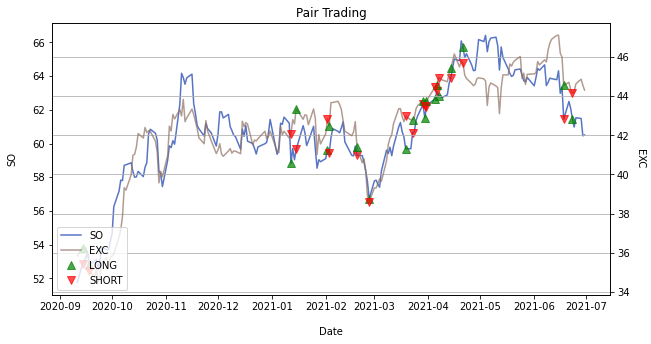

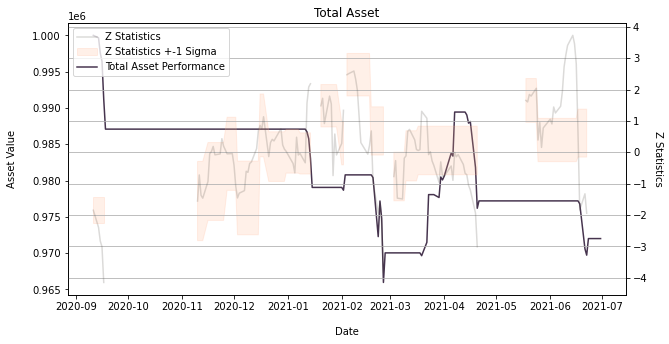

No handles with labels found to put in legend.



PERFORMANCE STATISTICS FOR MARKET NEUTRAL
Daily annualized sharpe: -1.4175475799505195
Average annual returns: -3.4928057412173446%
Total returns: -2.7997887290710457%
2020-09-11    0.000000
2020-09-14   -0.000335
2020-09-15   -0.002420
2020-09-16   -0.003572
2020-09-17   -0.008805
                ...   
2021-06-24   -0.027998
2021-06-25   -0.027998
2021-06-28   -0.027998
2021-06-29   -0.027998
2021-06-30   -0.027998
Name: daily_pnl, Length: 202, dtype: float64
Max drawdown: -3.4041389776273743%


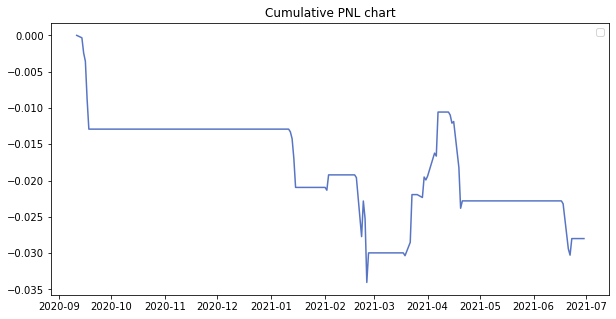

In [86]:
if __name__ == '__main__':
    main()

### 4.4.4 With Attention Analysis for 2020.07.01-2021.07.01 (Attention Analysis)

In [87]:
def getNewsCount (ticker,stdate,eddate):
    base_url = 'https://finnhub.io/api/v1/company-news?'
    token = 'c32t6giad3ifq943t68g'
    r = requests.get(base_url, params = {'symbol': ticker,'token':token, 'from':stdate, 'to':eddate})
    text = r.text
    
    company_news = json.loads(text)
    company_news_pd = pd.DataFrame(company_news)
    
    news_df = pd.concat([company_news_pd['headline'].apply(pd.Series)], axis=1)
    news_df.columns = ['headline']
    news_df['datetime'] = [(datetime.utcfromtimestamp(i).strftime('%Y-%m-%d %H:%M:%S')) for i in company_news_pd['datetime'] ]
    news_df['datetime'] = pd.to_datetime(news_df['datetime'])
    news_df.sort_values(by='datetime', inplace=True)
    
    # Apply the above function to get the trading time for each news headline
    news_df["trading_time"] = news_df["datetime"].apply(get_trade_open)
    news_df = news_df[pd.notnull(news_df['trading_time'])]
    news_df['Date'] = pd.to_datetime(pd.to_datetime(news_df['trading_time']).dt.date)
    
    news_df = news_df.reset_index(drop = True)
    Date_list = news_df['Date'].unique()
    
    news_count_list = []

    for j in range(len(Date_list)):
        news_count = 0
        for i in range(len(news_df['Date'])):
            if news_df['Date'].iloc[i] == Date_list[j]:
                news_count +=1
        news_count_list.append(news_count)
    
    
    final_news = pd.DataFrame(list(zip(Date_list, news_count_list)), columns = ['Date','news_count'])


    return final_news

In [88]:
def getNewsDF (ticker,stdate,eddate,num = 8):
    
    last_table = getNewsCount (ticker, stdate,eddate)
    oldest_date = '2020-07-25'
    
    for i in range(num):
        last_table_first_date = pd.Timestamp(last_table['Date'].iloc[0], tz=None).to_pydatetime().date()
        next_table = getNewsCount (ticker, stdate,last_table_first_date)
        next_table.drop(index=next_table.index[-1], axis=0, inplace=True)
        table_concat = pd.concat([next_table,last_table]).reset_index(drop = True)
        last_table = table_concat
        table_concat = table_concat.drop_duplicates(subset = ['Date'],keep = 'last').reset_index(drop = True)
        current_date = pd.Timestamp(table_concat['Date'].iloc[0], tz=None).to_pydatetime().date()
        if  current_date == oldest_date:
            break
    
    return table_concat

In [89]:
def signal_generation(asset1,asset2,method,pair_news,ticker1,ticker2, bandwidth=50):
    
    signals=pd.DataFrame()
    signals['asset1']=asset1['Close']
    signals['asset2']=asset2['Close']
    
    #signals only imply holding
    signals['signals1']=0    
    signals['signals2']=0
    
    #initialize
    prev_status=False
    signals['z']=np.nan
    signals['z upper limit']=np.nan
    signals['z lower limit']=np.nan
    signals['fitted']=np.nan    
    signals['residual']=np.nan
    signals = pd.merge(signals,pair_news,on = 'Date',how = 'outer').fillna(0).set_index('Date')
    signals = signals[signals['asset1']!=0]
    signals['asset1_news_count'] = signals[ticker1]
    signals['asset2_news_count'] = signals[ticker2]
    signals['news_count1_norm'] = np.nan
    signals['news_count2_norm'] = np.nan
    signals['news_asset1_Limit'] = np.nan
    signals['news_asset2_Limit'] = np.nan
    
    
    
    #signal processing
    for i in range(bandwidth,len(signals)):
        
        #cointegration test
        coint_status,model=EG_method(signals['asset1'].iloc[i-bandwidth:i],
                                  signals['asset2'].iloc[i-bandwidth:i])
                
        #cointegration breaks
        #clear existing positions
        if prev_status and not coint_status:           
            if signals.at[signals.index[i-1],'signals1']!=0:
                signals.at[signals.index[i],'signals1']=0
                signals.at[signals.index[i],'signals2']=0
                signals['z'].iloc[i:]=np.nan
                signals['z upper limit'].iloc[i:]=np.nan
                signals['z lower limit'].iloc[i:]=np.nan
                signals['fitted'].iloc[i:]=np.nan    
                signals['residual'].iloc[i:]=np.nan

        
        #cointegration starts
        #set the trigger conditions
        #this is no forward bias
        #just to minimize the calculation done in pandas
        if not prev_status and coint_status:
            
            #predict the price to compute the residual       
            signals['fitted'].iloc[i:]=model.predict(sm.add_constant(signals['asset1'].iloc[i:], prepend=True, has_constant='add'))
            signals['residual'].iloc[i:]=signals['asset2'].iloc[i:]-signals['fitted'].iloc[i:]
            
            #normalize the residual to get z stat
            #z should be a white noise following N(0,1)
            signals['z'].iloc[i:]=(signals['residual'].iloc[i:]-np.mean(model.resid))/np.std(model.resid)
                        
            #create thresholds
            #conventionally one sigma is the threshold
            #two sigma reaches 95% which is relatively difficult to trigger
            signals['z upper limit'].iloc[i:]=signals['z'].iloc[i]+np.std(model.resid)
            signals['z lower limit'].iloc[i:]=signals['z'].iloc[i]-np.std(model.resid)            

            #normalize the raw firm-specific news count for both firms in a pair 
            news1_mean = np.mean(signals['asset1_news_count'].iloc[i-bandwidth:i])
            news1_std = np.std(signals['asset1_news_count'].iloc[i-bandwidth:i])
            news2_mean = np.mean(signals['asset2_news_count'].iloc[i-bandwidth:i])
            news2_std = np.std(signals['asset2_news_count'].iloc[i-bandwidth:i])
            signals['news_count1_norm'].iloc[i:] = (signals['asset1_news_count'].iloc[i:] - news1_mean) / news1_std
            signals['news_count2_norm'].iloc[i:] = (signals['asset2_news_count'].iloc[i:] - news2_mean) / news2_std
            
            #create thresholds: 2 sd
            signals['news_asset1_Limit'].iloc[i:] = signals['news_count1_norm'].iloc[i] + 2 * np.std(signals['asset1_news_count'].iloc[i-bandwidth:i])                                                    
            signals['news_asset2_Limit'].iloc[i:] = signals['news_count2_norm'].iloc[i] + 2 * np.std(signals['asset2_news_count'].iloc[i-bandwidth:i])
                                            


#################################### No News Headline Sentiment #######################################3

        if coint_status and signals['z'].iloc[i]>signals['z upper limit'].iloc[i] and signals['news_count1_norm'].iloc[i] <= signals['news_asset1_Limit'].iloc[i] and signals['news_count2_norm'].iloc[i]<= signals['news_asset2_Limit'].iloc[i] :
            signals.at[signals.index[i],'signals1']=1
        if coint_status and signals['z'].iloc[i]<signals['z lower limit'].iloc[i] and signals['news_count1_norm'].iloc[i] <= signals['news_asset1_Limit'].iloc[i] and signals['news_count2_norm'].iloc[i]<= signals['news_asset2_Limit'].iloc[i] :
            signals.at[signals.index[i],'signals1']=-1 
        prev_status=coint_status  
    
    
    #signals only imply holding
    #we take the first order difference to obtain the execution signal
    signals['positions1']=signals['signals1'].diff()
    
    #only need to generate trading signal of one asset
    #the other one should be the opposite direction
    signals['signals2']=-signals['signals1']
    signals['positions2']=signals['signals2'].diff()   
    
    return signals



In [90]:
def singelPair(pair, capital,stdate,eddate,pair_news):
    
    ticker1=pair[0]
    ticker2=pair[1]

    #extract data
    asset1=yf.download(ticker1,start=stdate,end=eddate)
    asset2=yf.download(ticker2,start=stdate,end=eddate)  



    #create signals
    signals=signal_generation(asset1,asset2,EG_method, pair_news,ticker1,ticker2)

    #only viz the part where trading signals occur
    if signals['z'].dropna().size !=0:
        ind = signals['z'].dropna().index[0]
    else:ind = signals['z'].dropna()

    #viz positions
    plot(signals[ind:],ticker1,ticker2)    

    #viz portfolio performance
    portfolio_details=portfolio(signals[ind:], capital)
    signals.to_csv("signals_1.csv")
    return  portfolio_details

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


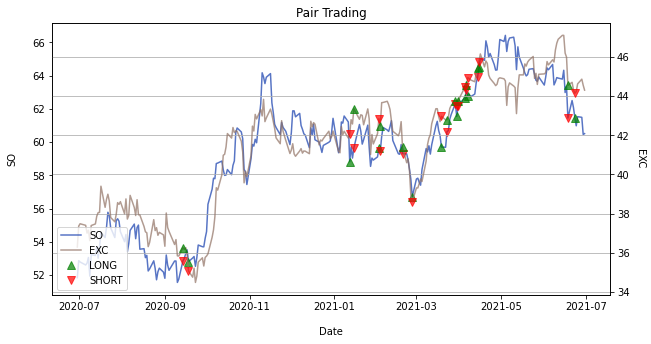

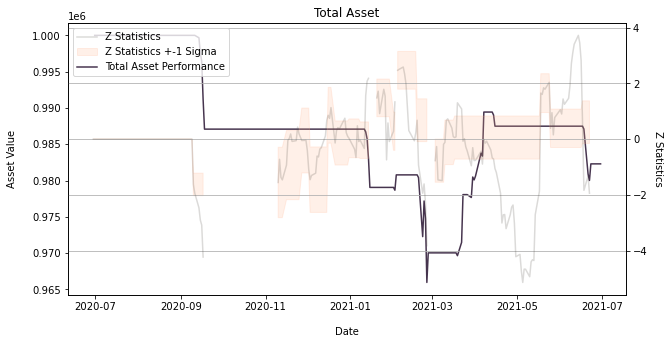

No handles with labels found to put in legend.



PERFORMANCE STATISTICS FOR MARKET NEUTRAL
Daily annualized sharpe: -0.8663200391549738
Average annual returns: -1.7704866279150115%
Total returns: -1.7704866279150127%
Date
2020-07-01    0.000000
2020-07-02    0.000000
2020-07-06    0.000000
2020-07-07    0.000000
2020-07-08    0.000000
                ...   
2021-06-24   -0.017705
2021-06-25   -0.017705
2021-06-28   -0.017705
2021-06-29   -0.017705
2021-06-30   -0.017705
Name: daily_pnl, Length: 252, dtype: float64
Max drawdown: -3.4041389776273743%


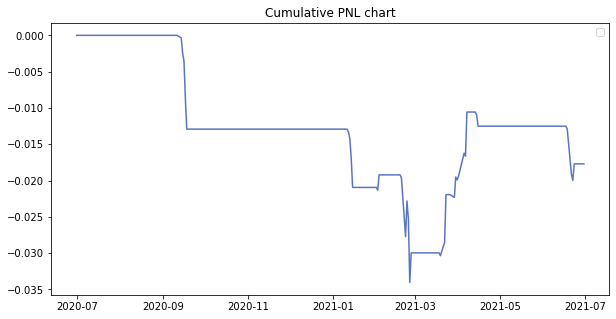

In [91]:
def main():
    stdate='2020-07-01'
    eddate='2021-07-01'
    total_capital = 1000000
    capital = total_capital/(len(pairs_top)*2)
    portfolio_details_list=[]
    for pair in pairs_top:
        
        #generate df of news counts 
        pair_news1 = getNewsDF(list(pair)[0],stdate,eddate)
        pair_news2 = getNewsDF(list(pair)[1],stdate,eddate)
        pair_news_data = pd.merge(pair_news1,pair_news2,on = 'Date',how = 'inner').fillna(0)
        pair_news_data.columns = ["Date",list(pair)[0],list(pair)[1]]
        
        
        pair_portfolio = singelPair(list(pair),capital,stdate,eddate,pair_news_data)
        portfolio_details_list.append(pair_portfolio["total asset"])
        
    
    overall_pnl = pd.concat(portfolio_details_list, axis=1,join="inner")
    overall_pnl = overall_pnl.iloc[1:]
    overall_pnl['pnl'] = overall_pnl.sum(axis=1)-total_capital
    overall_pnl['daily_pnl'] = (overall_pnl['pnl']-overall_pnl['pnl'].shift(periods=1, fill_value=overall_pnl['pnl'][0]/total_capital))/total_capital
    
    overall_pnl.to_csv("overall_portfolio.csv")
    pnlPerformance(overall_pnl['daily_pnl'], "MARKET NEUTRAL")
    

if __name__ == '__main__':
    main()